In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date, datetime, timezone
import os
import warnings

import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import pop_tools
import esmlab
import esmlab_regrid
print(esmlab_regrid.__version__) # Currently using ~/codes/esmlab_regrid (installed with pip -e from my fork)

from gen_remap_weights_1d import gen_remap_weights_1d
import config
import util

2019.5.2.dev12+g5a65521.d20211029


In [3]:
# script identifier to go in generated file

repo = 'github.com/marbl-ecosys/marbl-forcing'
sha = git.Repo(search_parent_directories=True).head.object.hexsha
script_fname = 'initial_conditions/gen_mom6_omip_IC.ipynb'
id_string = f'{repo}/tree/{sha}/{script_fname}'

In [4]:
# input specifications

add_cocco = True
split_zoo = True

tracernames = [ 'TEMP', 'SALT',
    'NO3', 'PO4', 'SiO3', 'O2', 'DIC', 'ALK', 
    'spC', 'spChl', 'spFe', 'spP', 
    'diatC', 'diatChl', 'diatFe', 'diatP', 'diatSi', 
    'diazC', 'diazChl', 'diazFe', 'diazP', 
    'DOC', 'DOCr', 'DON', 'DONr', 'DOP', 'DOPr', 'NH4', 
    'Fe', 'Lig'
]

# Either add coccolithophore tracers or make sp a calcifier
if add_cocco:
    cocco_tracers = ['coccoC', 'coccoChl', 'coccoFe', 'coccoP', 'coccoCaCO3']
    for tracername in cocco_tracers:
        tracernames.append(tracername)
else:
    cocco_tracers = []
    tracernames.append('spCaCO3')

# Either add multiple zooplankton tracers or just use zoo
if split_zoo:
    zoo_tracers = ['microzooC', 'mesozooC']
    for tracername in zoo_tracers:
        tracernames.append(tracername)
else:
    zoo_tracers = []
    tracernames.append('zooC')

# IC specified by OMIP (macronutrients, O2, DIC, ALK)
dirin_omip = '/glade/p/cesm/bgcwg/OMIPinit'
omip_metadata = {
    'TEMP':{'fname':'woa13_temperature_OMIPinit.nc', 'varname':'temp'},
    'SALT':{'fname':'woa13_salinity_OMIPinit.nc', 'varname':'salt'},
    'NO3':{'fname':'woa13_nitrate_OMIPinit.nc', 'varname':'no3'},
    'PO4':{'fname':'woa13_phosphate_OMIPinit.nc', 'varname':'po4'},
    'SiO3':{'fname':'woa13_silicate_OMIPinit.nc', 'varname':'si'},
    'O2':{'fname':'woa13_oxygen_OMIPinit.nc', 'varname':'o2'},
    'DIC':{'fname':'glodapv2_Ct_preind_OMIPinit.nc', 'varname':'Ct_preind'},
    'ALK':{'fname':'glodapv2_At_OMIPinit.nc', 'varname':'At'}
}

# Add grid name to metadata.
# This is fragile. It would be better to determine this automatically.
# Alternatively, the script would be more self contained if the grid were constructed on the fly.
omip_metadata['TEMP']['grid'] = 'latlon_1x1_180W'
omip_metadata['SALT']['grid'] = 'latlon_1x1_180W'
omip_metadata['NO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['PO4']['grid'] = 'latlon_1x1_180W'
omip_metadata['SiO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['O2']['grid'] = 'latlon_1x1_180W'
omip_metadata['DIC']['grid'] = 'latlon_1x1_20E'
omip_metadata['ALK']['grid'] = 'latlon_1x1_20E'

# get other tracers (living pools, DOM, NH4, Fe, Lig) from refcase
refcase = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
refdate = '0501-01-01'
dirin_refcase = f'{config.inputdata}/cesm2_init/{refcase}/{refdate}'
fname_refcase = f'{dirin_refcase}/{refcase}.pop.r.{refdate}-00000.nc'
print(fname_refcase)

/glade/p/cesmdata/cseg/inputdata/cesm2_init/b.e21.B1850.f09_g17.CMIP6-piControl.001/0501-01-01/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.r.0501-01-01-00000.nc


In [5]:
# details on file being generated

# dst_grid = 'MOM_tx0.66v1'
# ltripole = True
dst_grid = 'latlon_1x1_180W'
ltripole = False

interp_method = 'bilinear'
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{config.dirout}/ecosys_jan_IC_omip_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/work/mlevy/cesm_inputdata/ecosys_jan_IC_omip_latlon_1x1_180W_c231221.nc


In [6]:
# start ds_out as Dataset of grid variables
if dst_grid == 'MOM_tx0.66v1':
    # Open SCRIP grid file for basis of ds_out
    ds_out = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/share/scripgrids/tx0.66v1_SCRIP_190314.nc')
    ds_woa13 = xr.open_dataset(f'{dirin_omip}/woa13_nitrate_OMIPinit.nc', decode_times=False)

    # Set up horizontal coords
    ni, nj = ds_out.grid_dims.data
    ds_out.coords['LON'] = ('NLAT', 'NLON'), ds_out['grid_center_lon'].values.reshape(nj, ni)
    ds_out.coords['LON'].attrs = ds_woa13['lon'].attrs
    ds_out.coords['LAT'] = ('NLAT', 'NLON'), ds_out['grid_center_lat'].values.reshape(nj, ni)
    ds_out.coords['LAT'].attrs = ds_woa13['lat'].attrs

    # Vertical grid will come from WOA data!
    print('Creating depth variable from WOA levels')
    DEPTH = ds_woa13['depth'].rename({'depth' : 'DEPTH'})
    del DEPTH.attrs['bounds']
    del DEPTH.attrs['standard_name']
    DEPTH_bounds = ds_woa13['depth_bnds']
    ds_out.coords['DEPTH'] = DEPTH
    ds_out['DEPTH'].attrs
    lon_name='LON'
    lat_name='LAT'
elif dst_grid == 'latlon_1x1_180W':
    # TODO: build ds_out up from WOA rather than SCRIP file
    ds_out = xr.open_dataset(f'{dirin_omip}/woa13_nitrate_OMIPinit.nc', decode_times=False).rename({'lon': 'NLON', 'lat': 'NLAT', 'depth': 'DEPTH'})
    DEPTH_bounds = ds_out['depth_bnds']
    ni = len(ds_out.NLON)
    nj = len(ds_out.NLAT)
    del ds_out['no3']
    del ds_out['depth_bnds']
    del ds_out.attrs['history']
    del ds_out.attrs['Conventions']
    lon_name='NLON'
    lat_name='NLAT'
else:
    raise ValueError(f'Unknown dst_grid "{dst_grid}"')

# clean-up regardless of dst_grid
del ds_out.coords[lon_name].attrs['axis']
del ds_out.coords[lon_name].attrs['point_spacing']
del ds_out.coords[lat_name].attrs['axis']
del ds_out.coords[lat_name].attrs['point_spacing']
nk = len(ds_out.DEPTH)

# Introduce 1D coords so we can read this file with new MOM6 API
if dst_grid == 'MOM_tx0.66v1':
    ds_out['NLAT'] = ds_out.coords['LAT'].isel(NLON=142) # 142 is where max latitude occurs
    ds_out['NLAT'].attrs = ds_out.coords['LAT'].attrs
    ds_out['NLON'] = ds_out.coords['LON'].isel(NLAT=0)
    ds_out['NLON'].attrs = ds_out.coords['LON'].attrs

# Vertical mask: for MOM grid, find last level in WOA data where MOM cell depth is > top of cell
if dst_grid == 'MOM_tx0.66v1':
    inputdata = '/glade/p/cesmdata/cseg/inputdata/'
    cell_depth = xr.open_dataset(inputdata+'ocn/mom/tx0.66v1/ocean_topog_190314.nc')['depth'].data
    active_level_count = np.zeros(cell_depth.shape)
    for k, depth in enumerate(DEPTH.data):
        active_level_count = np.where(cell_depth>=depth, k, active_level_count)
    # if cell_depth is deeper than largest DEPTH, it is active at very last cell
    active_level_count = np.where(cell_depth>np.max(DEPTH.data), nk+1, active_level_count)

    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('DEPTH'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('DEPTH', 'NLAT', 'NLON'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < active_level_count)
    MASK = xr.where(MASK.notnull(), True, False)
    inputdata = '/glade/p/cesmdata/cseg/inputdata/'
    cell_depth = xr.open_dataset(inputdata+'ocn/mom/tx0.66v1/ocean_topog_190314.nc')['depth'].data
    active_level_count = np.zeros(cell_depth.shape)
    active_level_count = np.where(cell_depth>0, nk+1, 0)
    
    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('DEPTH'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('DEPTH', 'NLAT', 'NLON'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < active_level_count)
    MASK = xr.where(MASK.notnull(), True, False)
    MASK.assign_coords({'DEPTH': ds_out.DEPTH.data})

# if dst_grid == 'latlon_1x1_180W':
#     MASK = xr.where(ds_woa13['no3'].isel(time=0).notnull(), True, False).rename({'depth': 'DEPTH', 'lat': 'NLAT', 'lon': 'NLON'}).assign_coords({'NLON': ds_out.NLON.data})

print(f'ni = {ni}, nj = {nj}, and nk = {nk}')

ni = 360, nj = 180, and nk = 102


In [7]:
# Add MOM6 grid to regrid settings (super kludgy!)
if dst_grid == 'MOM_tx0.66v1':
    with open('MOM_grid.yaml') as gridfile:
        MOM6_regrid = yaml.safe_load(gridfile)
    regrid_settings = esmlab.config.get('regrid')
    regrid_settings['grids']['MOM_tx0.66v1'] = MOM6_regrid
    esmlab.config.set({'regrid' : regrid_settings});

USER = os.environ['USER']

regridding TEMP from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [-2.090459942817688, 30.24555492401123]
Range on output grid: [-2.090459942817688, 30.24555492401123]



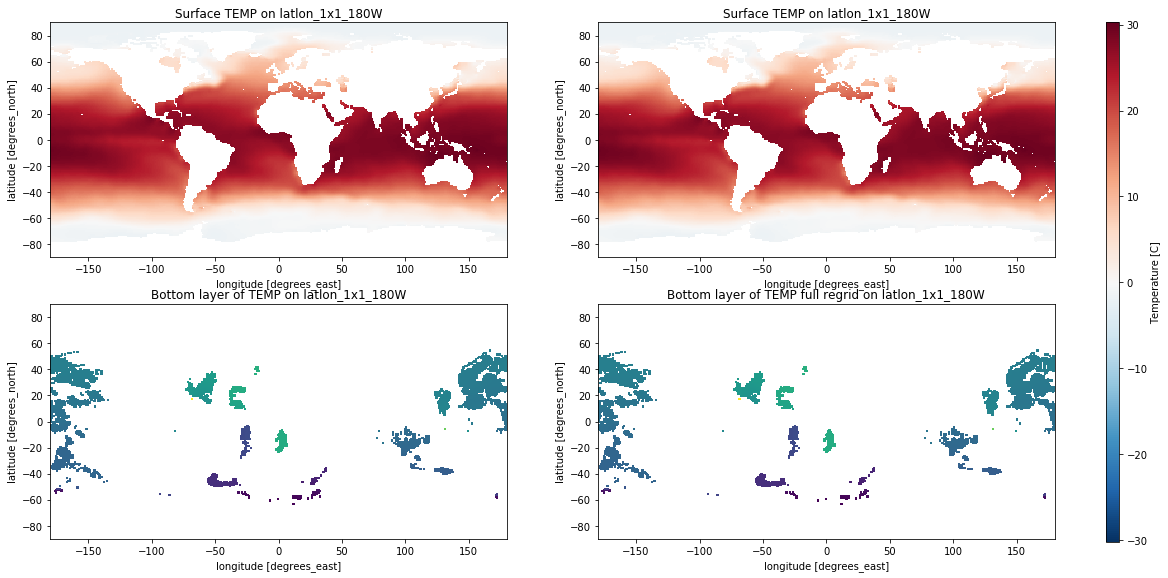


----

regridding SALT from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [5.073745012283325, 40.5940055847168]
Range on output grid: [5.073745012283325, 40.5940055847168]



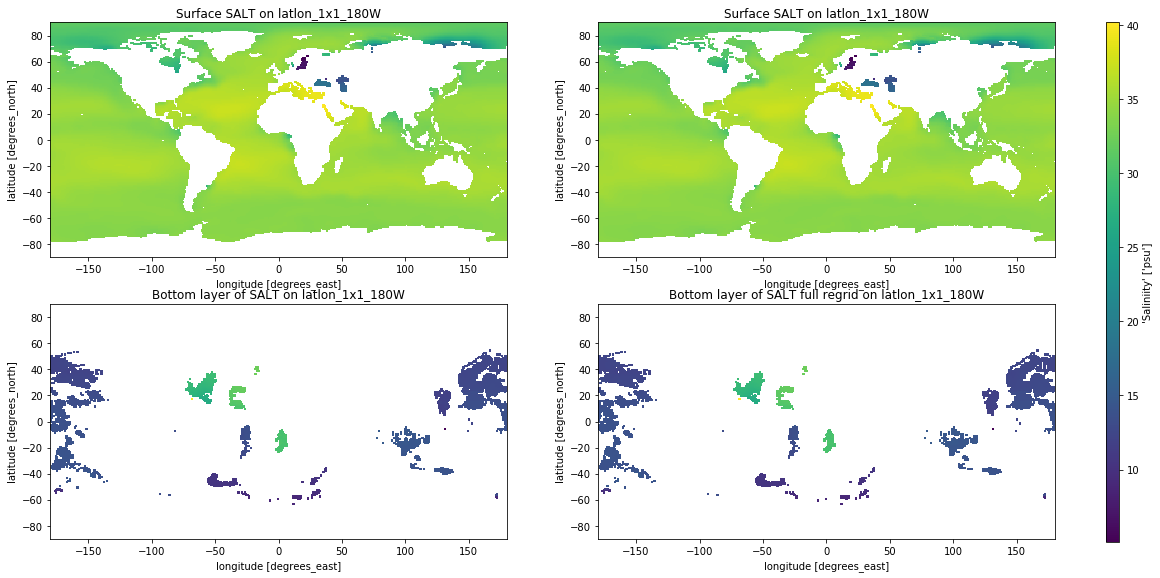


----

regridding NO3 from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [0.0, 56.12459182739258]
Range on output grid: [0.0, 56.12459182739258]



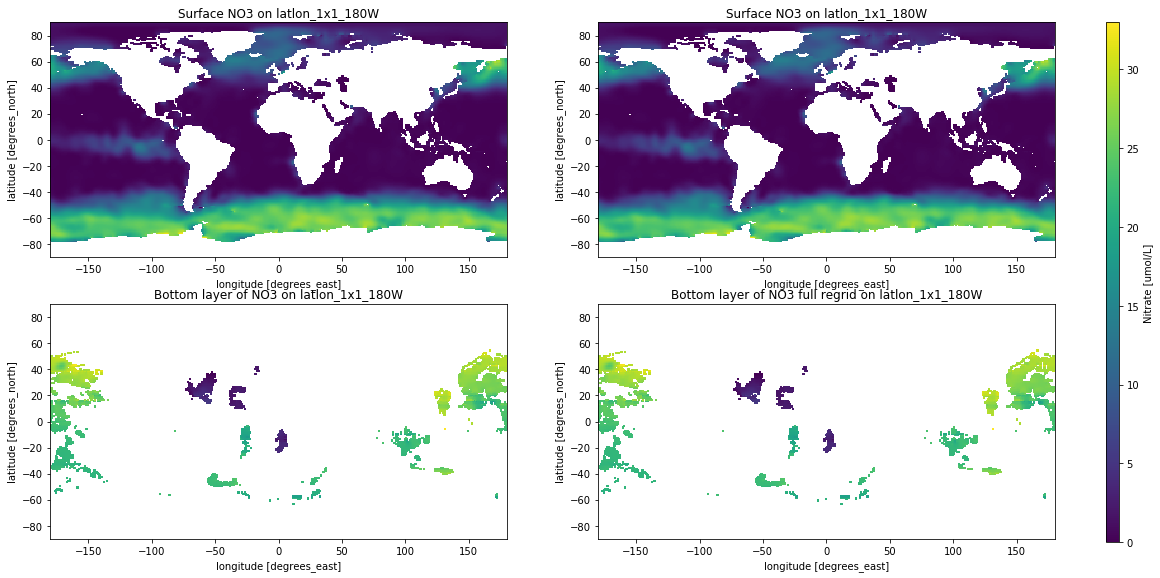


----

regridding PO4 from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [0.0, 11.620512008666992]
Range on output grid: [0.0, 11.620512008666992]



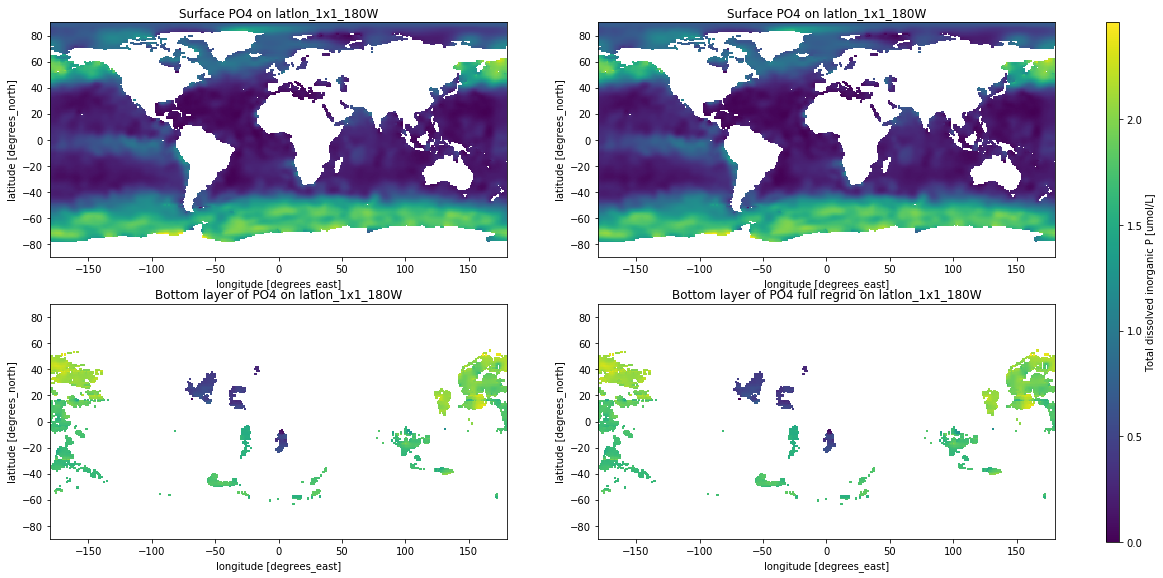


----

regridding SiO3 from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [0.0, 258.23114013671875]
Range on output grid: [0.0, 258.23114013671875]



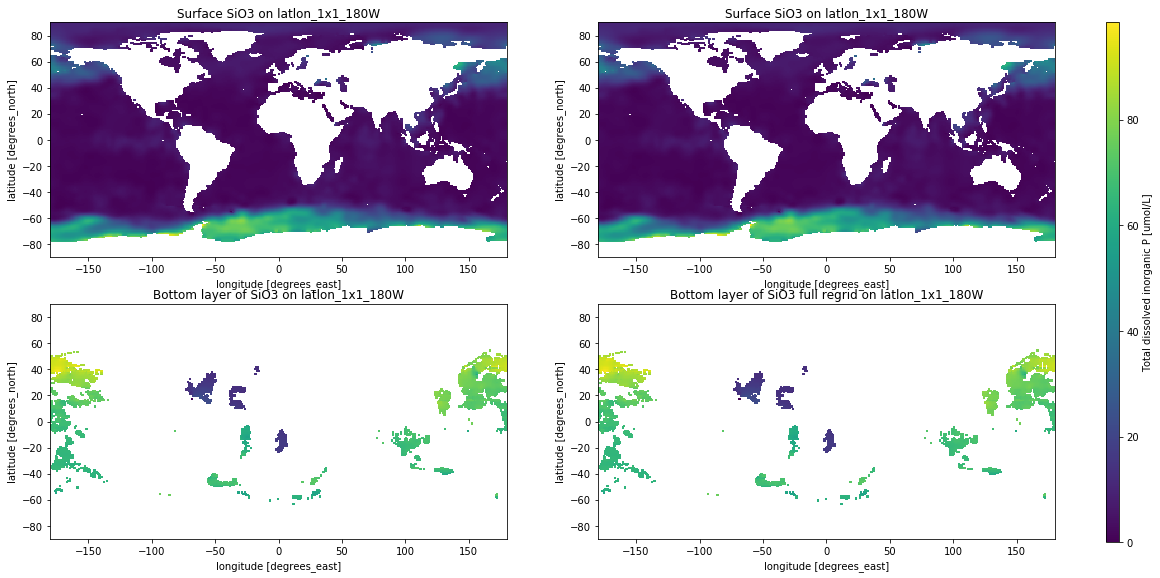


----

regridding O2 from latlon_1x1_180W to latlon_1x1_180W

Range on native grid: [0.0, 10.264282703399658]
Range on output grid: [0.0, 10.264282703399658]



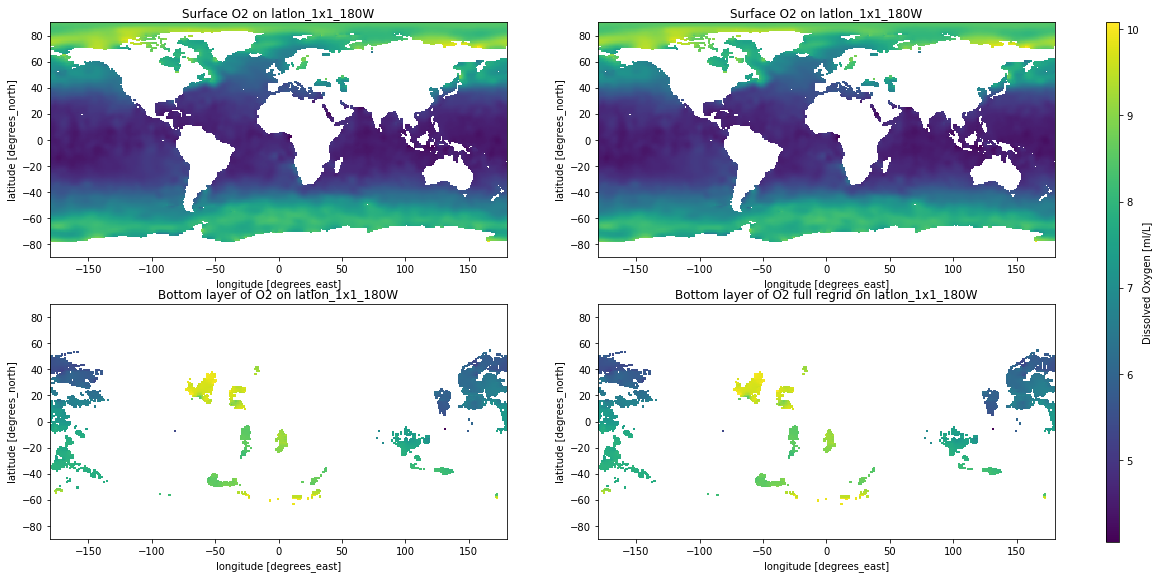


----

regridding DIC from latlon_1x1_20E to latlon_1x1_180W

Range on native grid: [1190.2440185546875, 2398.614990234375]
Range on output grid: [1190.2440185546875, 2398.614990234375]



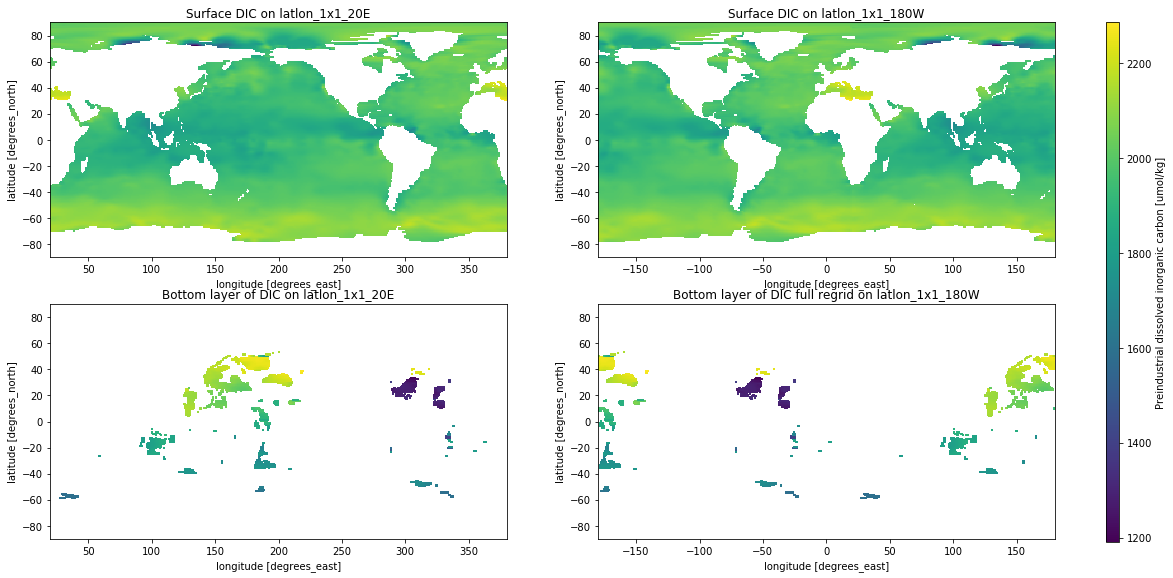


----

regridding ALK from latlon_1x1_20E to latlon_1x1_180W

Range on native grid: [1301.5667724609375, 2659.830810546875]
Range on output grid: [1301.5667724609375, 2659.830810546875]



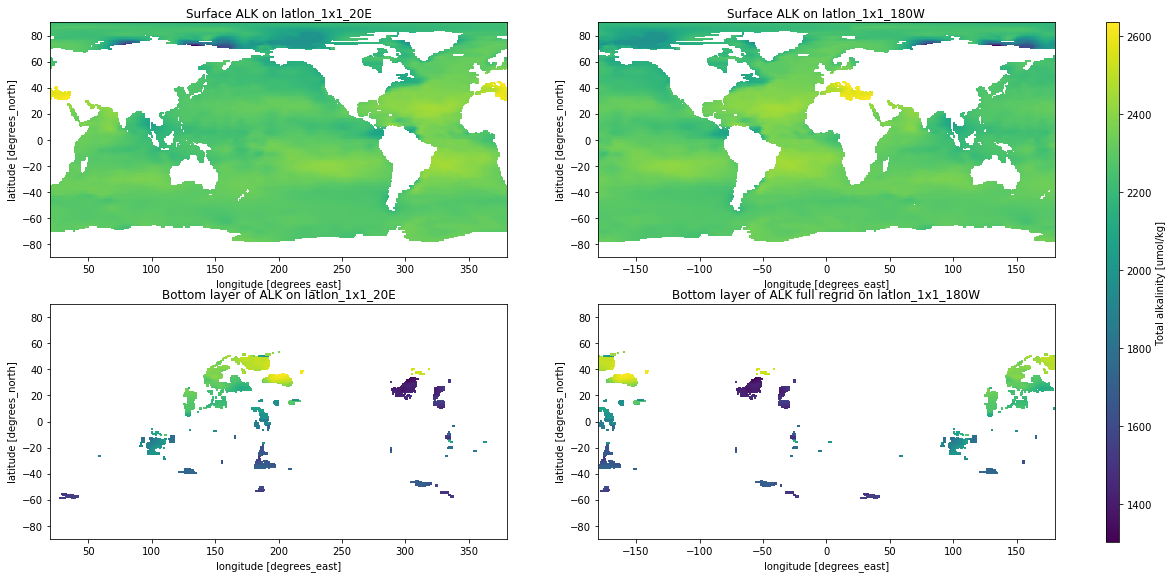


----

<xarray.Dataset>
Dimensions:  (DEPTH: 102, NLAT: 180, NLON: 360, time: 1)
Coordinates:
  * NLON     (NLON) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * NLAT     (NLAT) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * DEPTH    (DEPTH) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
  * time     (time) float32 6.0
Data variables:
    TEMP     (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    DIC      (DEPTH, NLAT, NLON) float64 nan nan nan nan nan ... nan nan nan nan
    ALK      (DEPTH, NLAT, NLON) float64 nan nan nan nan n

In [8]:
%%time
%matplotlib inline
for tracername in omip_metadata:
    # decode_times=False because omip files have unsupported units
    #     "months since 0000-01-01 00:00:00"
    ds_omip = xr.open_dataset(dirin_omip+'/'+omip_metadata[tracername]['fname'], decode_times=False)

    varname_omip = omip_metadata[tracername]['varname']

    src_grid = omip_metadata[tracername]['grid']
    print(f'regridding {tracername} from {src_grid} to {dst_grid}\n')
    
    # Plot on src grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.0, 9.5))
    # plt.subplot(121)
    # try:
    #     ds_omip[varname_omip].isel(time=0, depth=0).plot(add_colorbar=False)
    # except:
    #     ds_omip[varname_omip].isel(depthz=0).plot(add_colorbar=False)
    # plt.title(f"Surface {varname_omip} on {src_grid}")
    # surface values
    plt.subplot(221)
    try:
        ds_omip[varname_omip].isel(time=0, depth=0).plot(add_colorbar=False)
    except:
        ds_omip[varname_omip].isel(depthz=0).plot(add_colorbar=False)
    plt.title(f"Surface {tracername} on {src_grid}")

    # bottom values
    plt.subplot(223)
    try:
        vmin, vmax = ds_omip[varname_omip].isel(time=0, depth=-1).min(), ds_omip[varname_omip].isel(time=0, depth=-1).max()
        ds_omip[varname_omip].isel(time=0, depth=-1).plot(add_colorbar=False, vmin=vmin, vmax=vmax)
    except:
        vmin, vmax = ds_omip[varname_omip].isel(depthz=-1).min(), ds_omip[varname_omip].isel(depthz=-1).max()
        ds_omip[varname_omip].isel(depthz=-1).plot(add_colorbar=False, vmin=vmin, vmax=vmax)
    plt.title(f"Bottom layer of {tracername} on {src_grid}")

    tracer_omip = ds_omip[varname_omip]
    if 'time' in tracer_omip.dims:
        tracer_omip = tracer_omip.isel(time=0, drop=True)

    # generate vertical remapping weights
    depth_name_in = tracer_omip.dims[0]
    depth_bounds_name = ds_omip[depth_name_in].attrs['bounds']
    depth_remap_weights = gen_remap_weights_1d(
        ds_omip[depth_bounds_name], DEPTH_bounds,
        ds_omip[depth_name_in].attrs['units'], 'm')

    # perform vertical remapping
    nk_in, nj_in, ni_in = tracer_omip.shape
    tracer_omip_flat = tracer_omip.values.reshape((nk_in, nj_in*ni_in))
    tracer_vertical_regrid_flat = depth_remap_weights.dot(tracer_omip_flat)
    tracer_vertical_regrid_values = tracer_vertical_regrid_flat.reshape((nk, nj_in, ni_in))
    tracer_vertical_regrid = xr.DataArray(tracer_vertical_regrid_values, dims=('DEPTH', 'NLAT', 'NLON'),
                                          coords={'DEPTH':ds_out.DEPTH, 'NLAT': tracer_omip.lat.data, 'NLON': tracer_omip.lon.data},
                                          attrs=tracer_omip.attrs)

    if dst_grid == 'MOM_tx0.66v1':
        # perform lateral remapping
        regrid_operator = esmlab_regrid.regridder(
            name_grid_src=omip_metadata[tracername]['grid'], 
            name_grid_dst=dst_grid, method=interp_method, overwrite_existing=False)
        tracer_full_regrid = regrid_operator(tracer_vertical_regrid, renormalize=True)
        tracer_full_regrid = tracer_full_regrid.where(MASK)
        tracer_full_regrid.encoding['_FillValue'] = tracer_omip.encoding['_FillValue']

        # perform lateral fill (need in mom_tools!)
        tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MASK, ltripole=ltripole)

    if dst_grid == 'latlon_1x1_180W':
        if omip_metadata[tracername]['grid'] == 'latlon_1x1_180W':
            tracer_full_regrid = tracer_vertical_regrid
        if omip_metadata[tracername]['grid'] == 'latlon_1x1_20E':
            # Verified offline that .roll(lon=200, roll_coords=True) results in
            # (lon) float64 180.5 181.5 182.5 183.5 ... 176.5 177.5 178.5 179.5
            tracer_full_regrid = tracer_vertical_regrid.roll(NLON=200, roll_coords=True)
        tracer_full_regrid = tracer_full_regrid.assign_coords({dimname: ds_out[dimname] for dimname in ['DEPTH', 'NLON', 'NLAT']})
        tracer_full_regrid.encoding['_FillValue'] = tracer_omip.encoding['_FillValue']

    ds_out[tracername] = tracer_full_regrid

    # Plot surface values
    plt.subplot(222)
    my_plot = ds_out[tracername].isel(DEPTH=0).plot(add_colorbar=False)
    plt.title(f'Surface {tracername} on {dst_grid}')
    cax = plt.axes((0.94, 0.12, 0.01, 0.76))
    cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
    cbar.set_label('{} [{}]'.format(ds_out[tracername].attrs['long_name'],
                                    ds_out[tracername].attrs['units']),
                                    rotation=90)
    # plot bottom layer (mom horizontal, mom vertical grid)
    plt.subplot(224)
    ds_out[tracername].isel(DEPTH=-1).plot(add_colorbar=False, vmin=vmin, vmax=vmax)
    plt.title(f"Bottom layer of {tracername} full regrid on {dst_grid}")    # Plot data
    # plt.subplot(122)
    # my_plot = ds_out[tracername].isel(DEPTH=0).plot(add_colorbar=False)
    # plt.title(f'Surface {tracername} on {dst_grid}')
    # cax = plt.axes((0.94, 0.12, 0.01, 0.76))
    # cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
    # cbar.set_label('{} [{}]'.format(ds_out[tracername].attrs['long_name'], ds_out[tracername].attrs['units']), rotation=90)
    
    print(f"Range on native grid: [{tracer_omip.min().data}, {tracer_omip.max().data}]")
    print(f"Range on output grid: [{ds_out[tracername].min().data}, {ds_out[tracername].max().data}]\n")
    plt.show()
    print('\n----\n')
    
print(ds_out)

In [9]:
rho_0 = 1.026
# change units of omip vars to model units
for tracername in omip_metadata:
    units = ds_out[tracername].attrs['units']
    if 'kg' in units:
        ds_out[tracername].values *= rho_0
        ds_out[tracername].attrs['units'] = units.replace('kg', 'L')
        ds_out[tracername].attrs['rho_0'] = rho_0
    if tracername == 'O2' and (units == 'ml/L' or units == 'milliliters_per_liter'):
        ds_out[tracername].values *= (1.0e3 / 22.3916)
        ds_out[tracername].attrs['units'] = 'umol/L'

need to include spC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Scaling spC to 93%
Old max = 34.7047697909609
New max = 32.27543590559364
Updating dimension
Range on POP grid: [-0.5545913688083207, 32.27543590559364]
Range on output grid: [0.0, 31.81149821773885]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


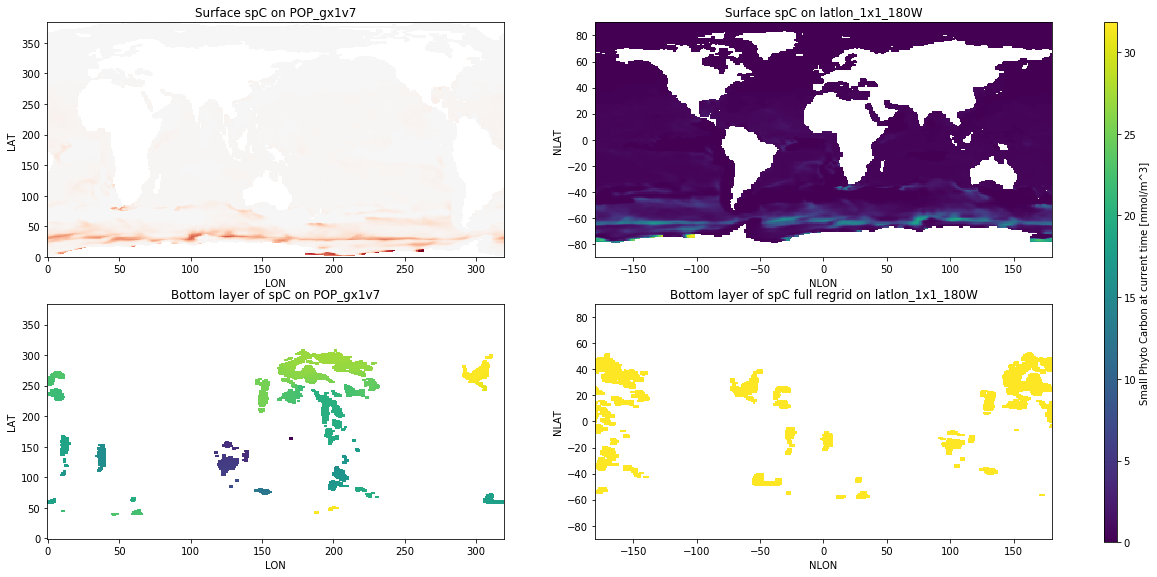


----

need to include spChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Scaling spChl to 93%
Old max = 4.088909397055873
New max = 3.8026857392619617
Updating dimension
Range on POP grid: [-0.07651563079568215, 3.8026857392619617]
Range on output grid: [0.0, 3.7681341305056564]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


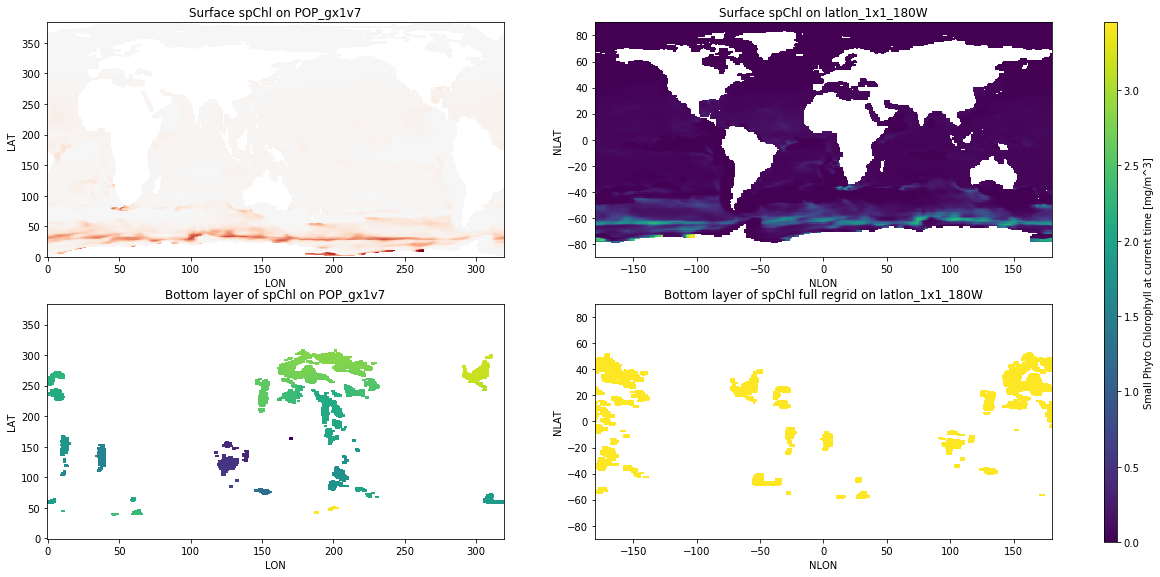


----

need to include spFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Scaling spFe to 93%
Old max = 0.0002570055515573563
New max = 0.00023901516294834137
Updating dimension
Range on POP grid: [-3.885516801858003e-06, 0.00023901516294834137]
Range on output grid: [0.0, 0.00023450139443611425]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


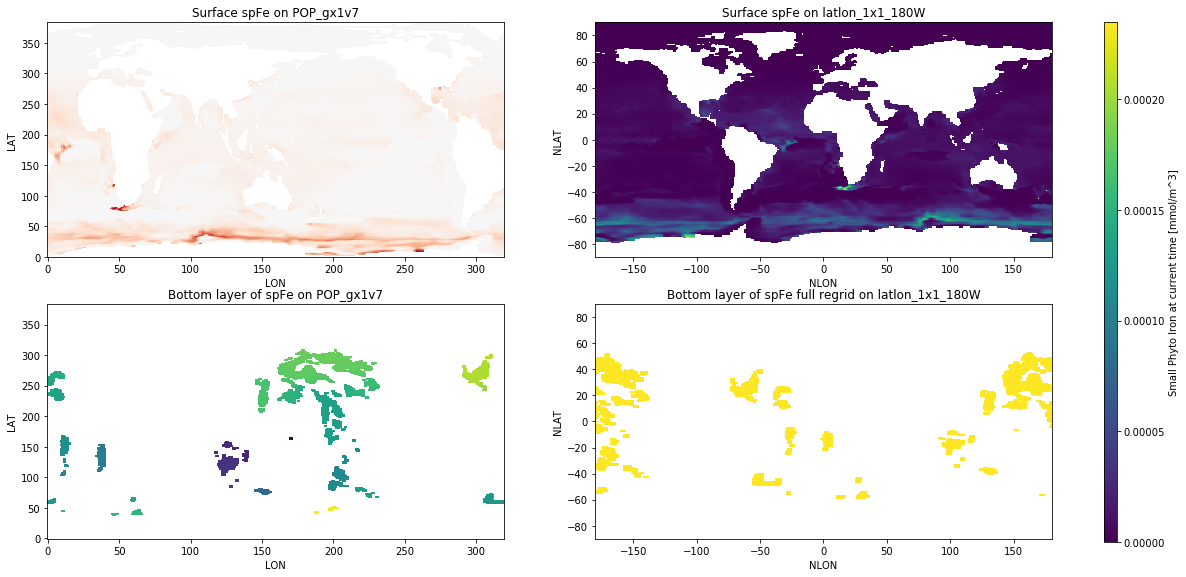


----

need to include spP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Scaling spP to 93%
Old max = 0.2966220135408344
New max = 0.275858472592976
Updating dimension
Range on POP grid: [-0.004740098920460367, 0.275858472592976]
Range on output grid: [0.0, 0.2718931925381876]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


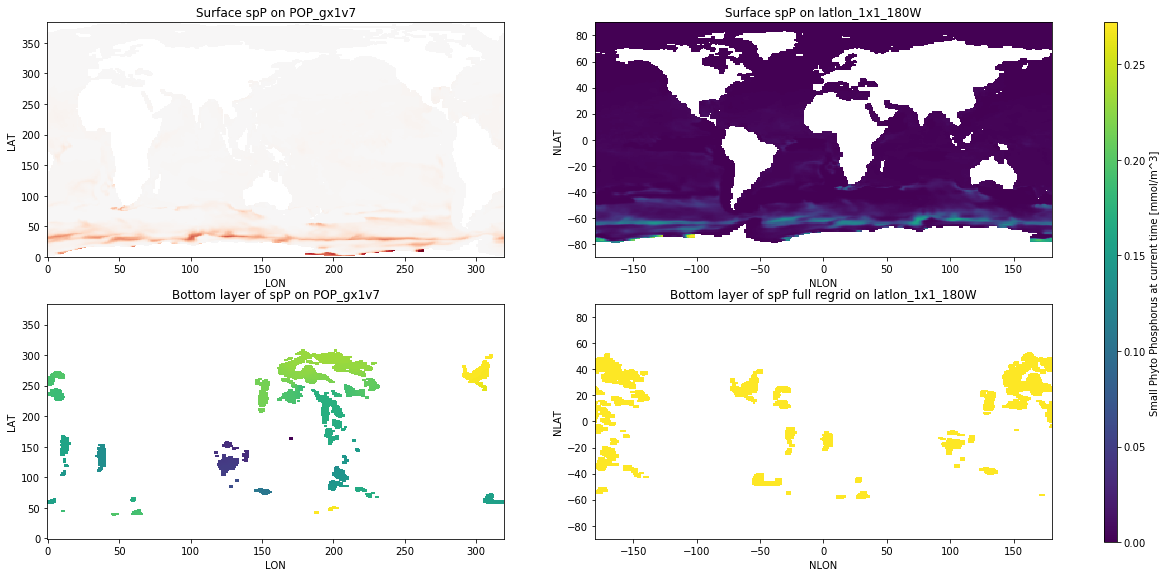


----

need to include diatC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-6.1243168363559155, 106.66184270617225]
Range on output grid: [0.0, 63.66978096453058]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


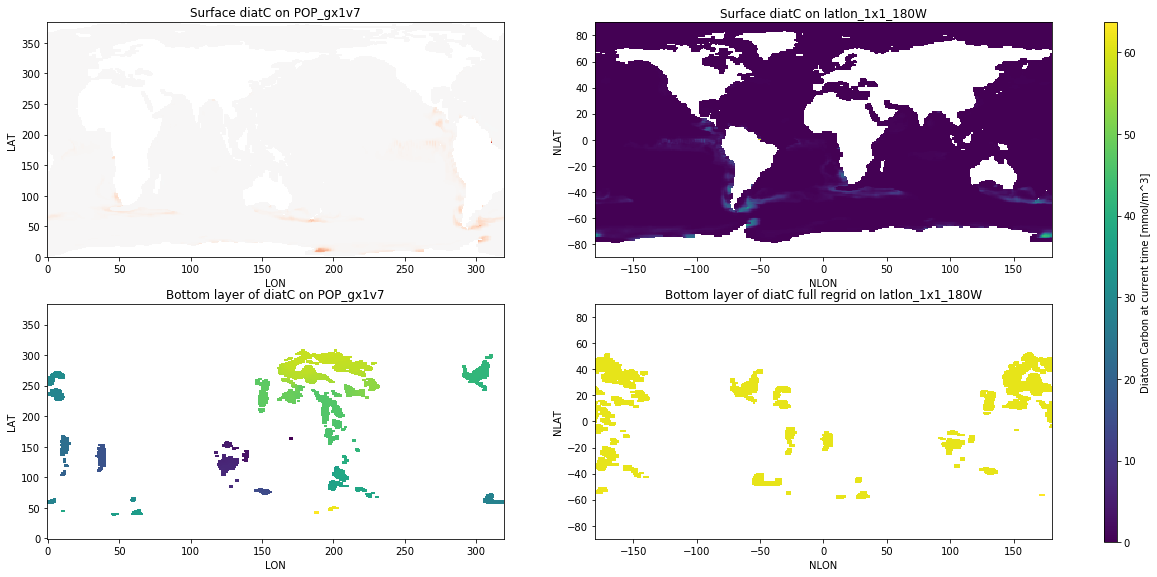


----

need to include diatChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-1.9372336029813024, 32.48634820148797]
Range on output grid: [0.0, 17.509750161296456]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


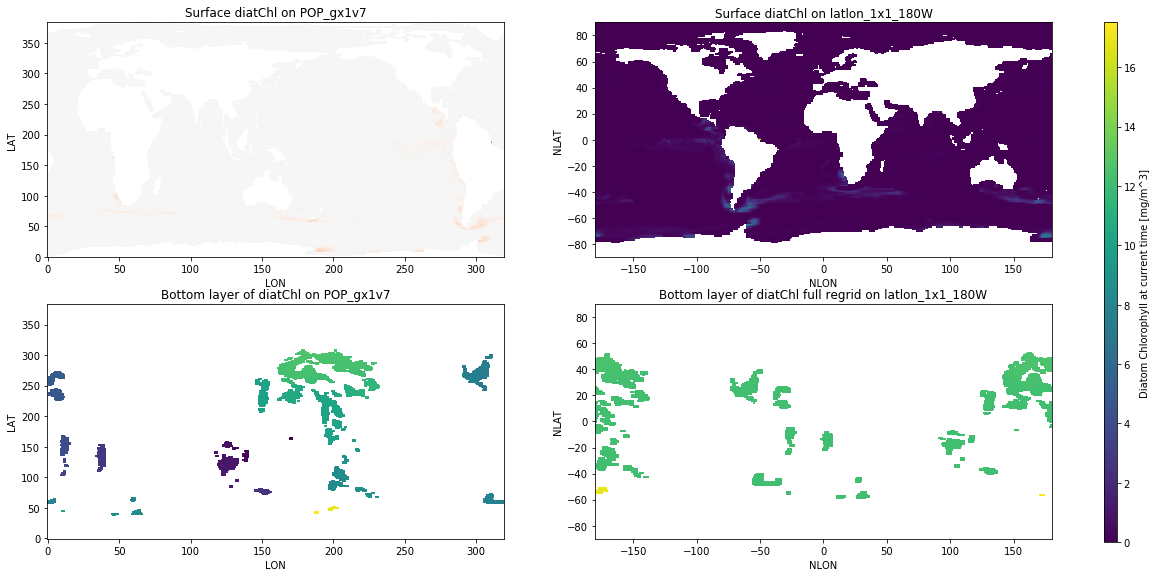


----

need to include diatFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.00017117463486542383, 0.003123639447157943]
Range on output grid: [0.0, 0.0015724632076729794]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


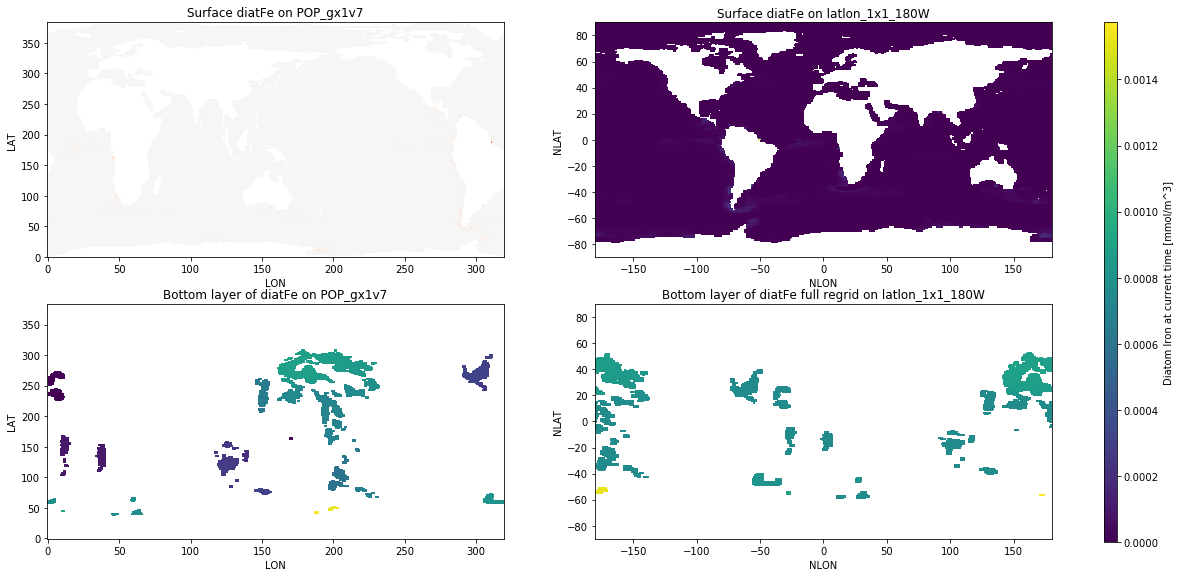


----

need to include diatP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.04296400986045514, 0.723854212863459]
Range on output grid: [0.0, 0.41865869665772415]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


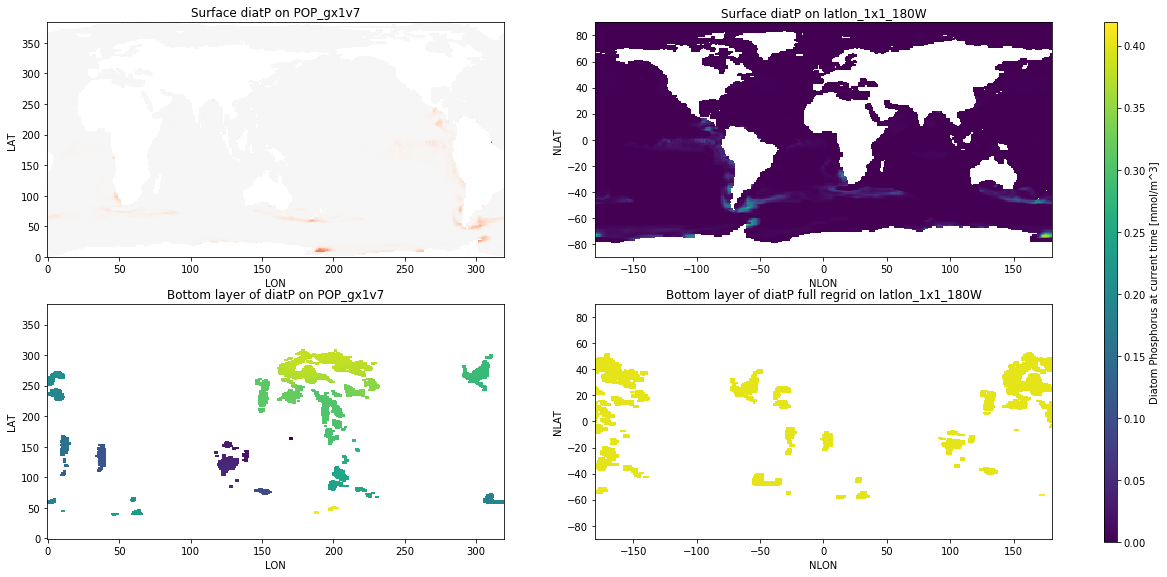


----

need to include diatSi from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.9664037469841574, 28.669146355839818]
Range on output grid: [0.0, 27.362727703824785]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


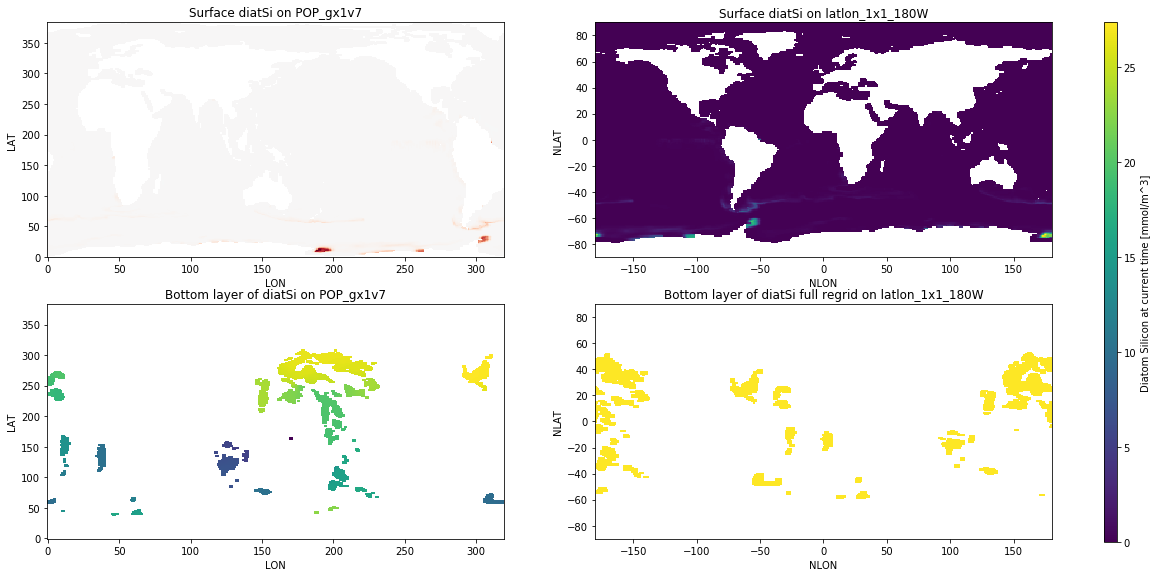


----

need to include diazC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.02430420679463188, 0.5658213552775817]
Range on output grid: [0.0, 0.5658213552775818]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


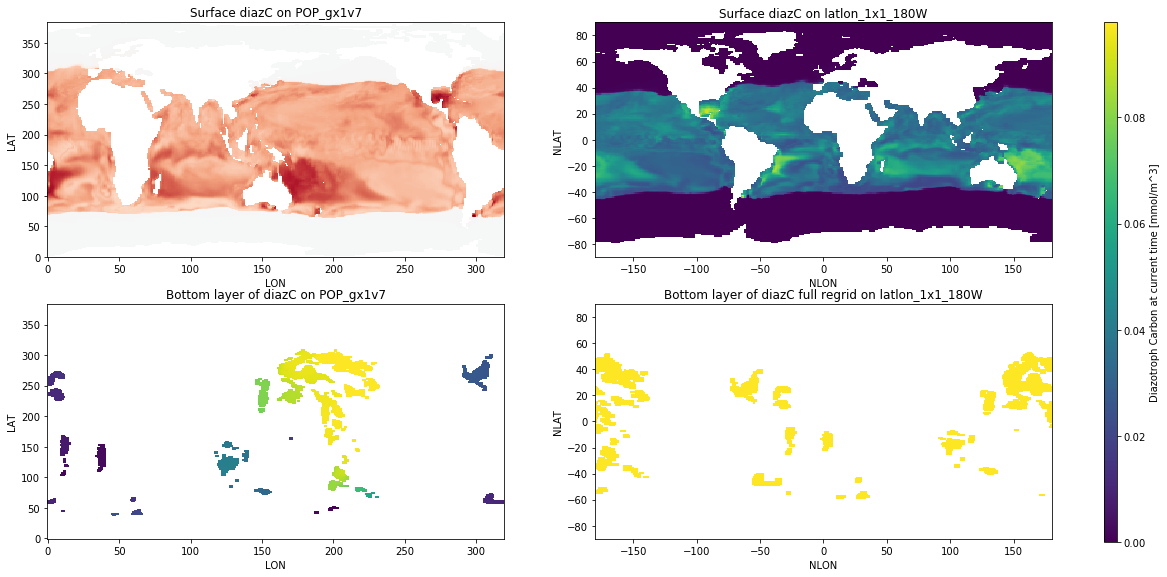


----

need to include diazChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.006291056115108507, 0.15850352000383466]
Range on output grid: [0.0, 0.15850352000383466]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


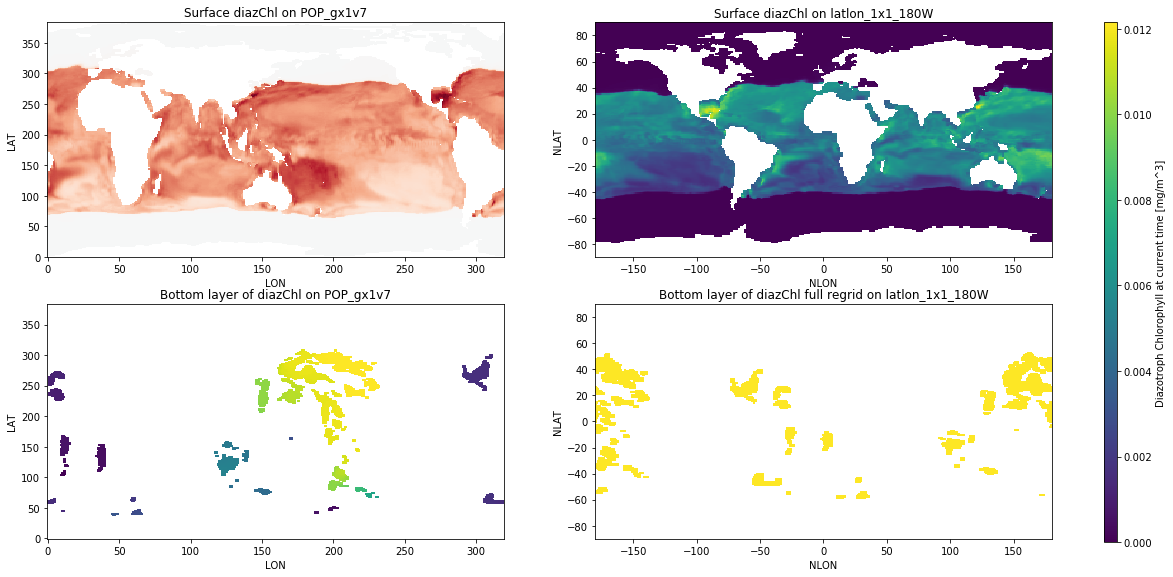


----

need to include diazFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-1.4529363481973322e-06, 3.3950863869892814e-05]
Range on output grid: [0.0, 3.3950863869892814e-05]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


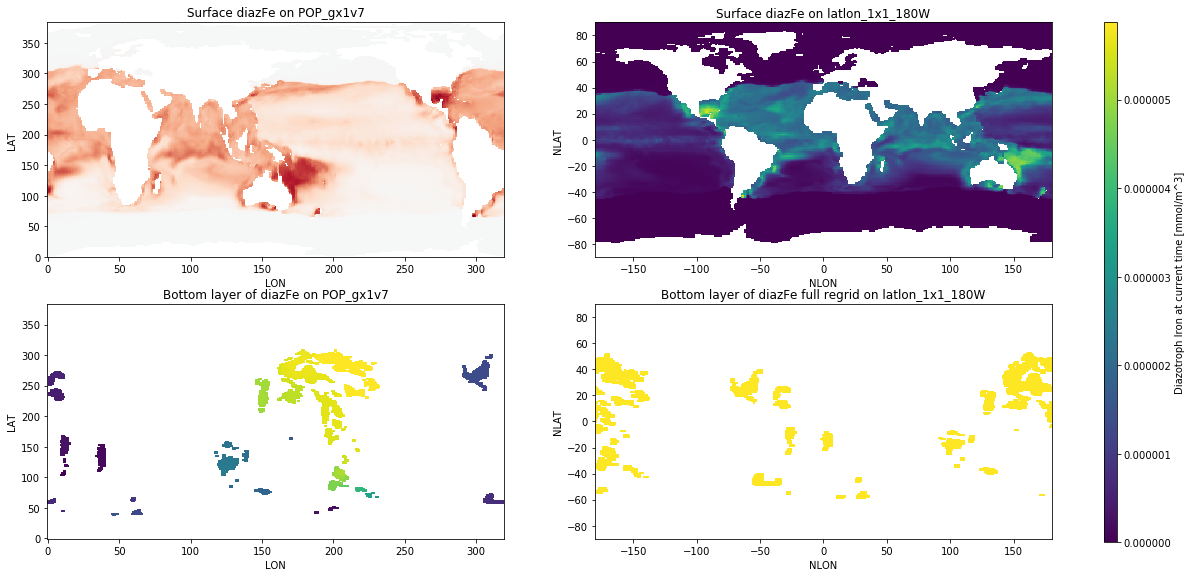


----

need to include diazP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.0002077277059609195, 0.0048360808378243286]
Range on output grid: [0.0, 0.0048360808378243286]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


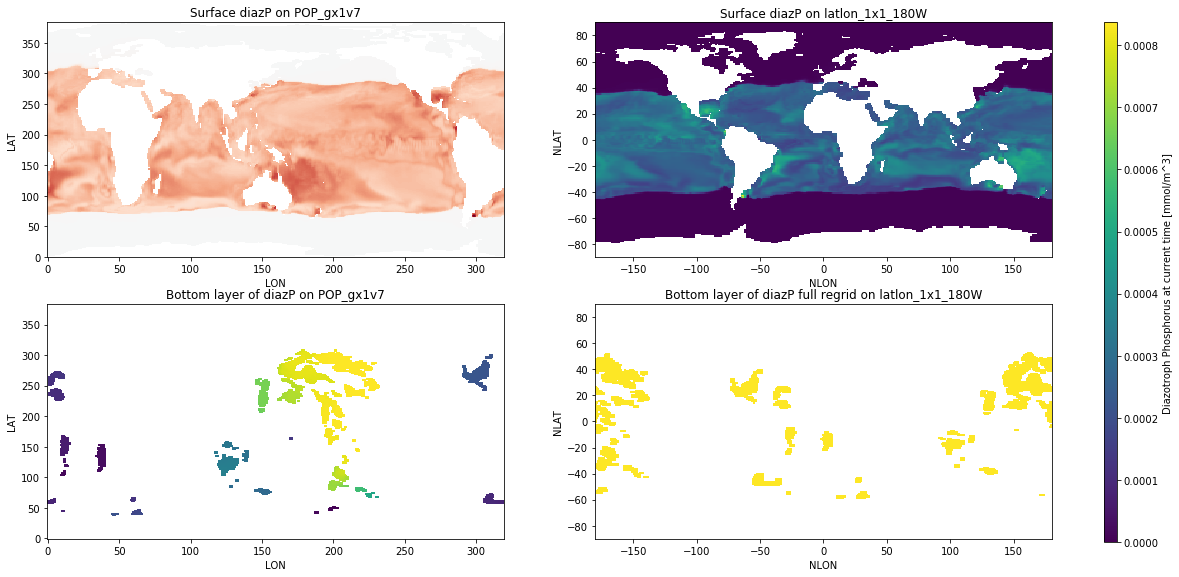


----

need to include DOC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-21.680804743348627, 536.1286767905538]
Range on output grid: [0.0, 417.3188715177016]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


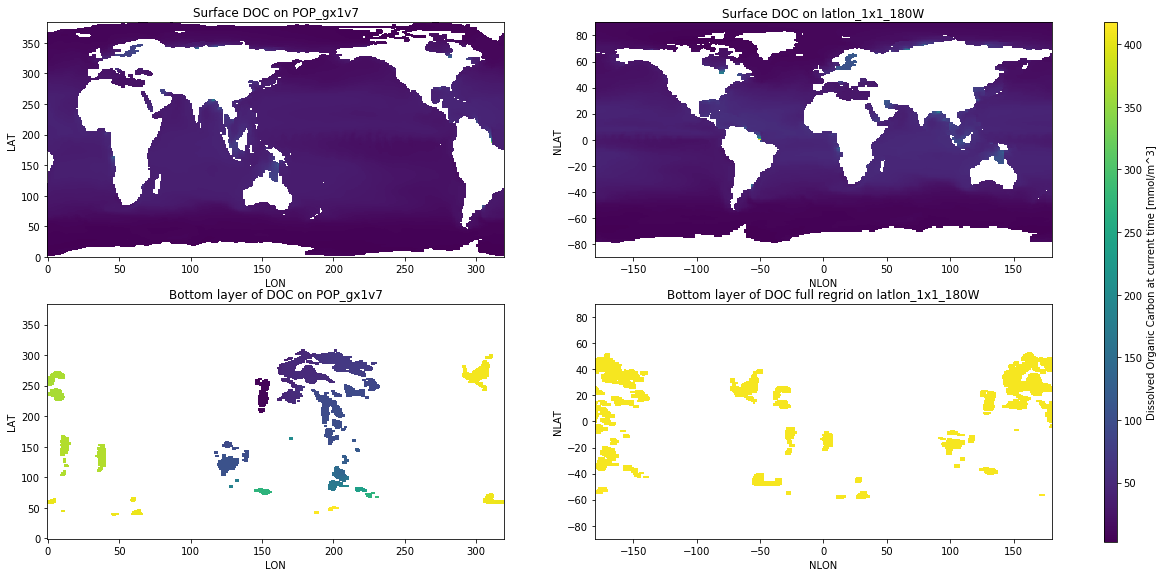


----

need to include DOCr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [6.84178242382656, 160.09607018270341]
Range on output grid: [19.298054268752747, 160.09607018270341]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


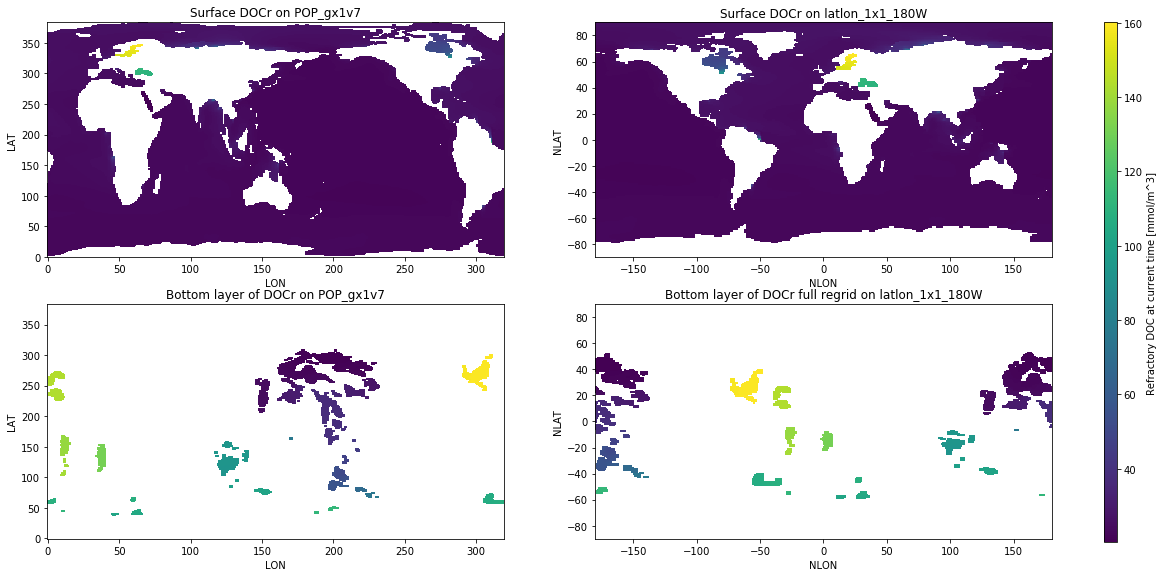


----

need to include DON from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-1.7352356096564938, 21.751638796341105]
Range on output grid: [0.0, 17.669741639982448]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


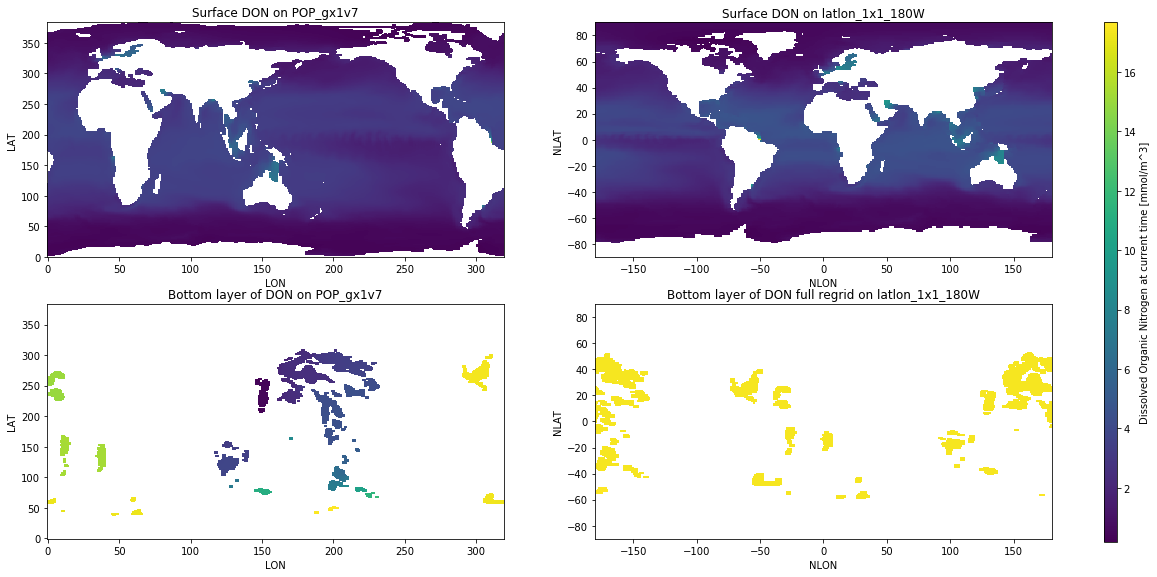


----

need to include DONr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [0.8381150735816362, 3.729778786252812]
Range on output grid: [0.8381150735816362, 3.729778786252812]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


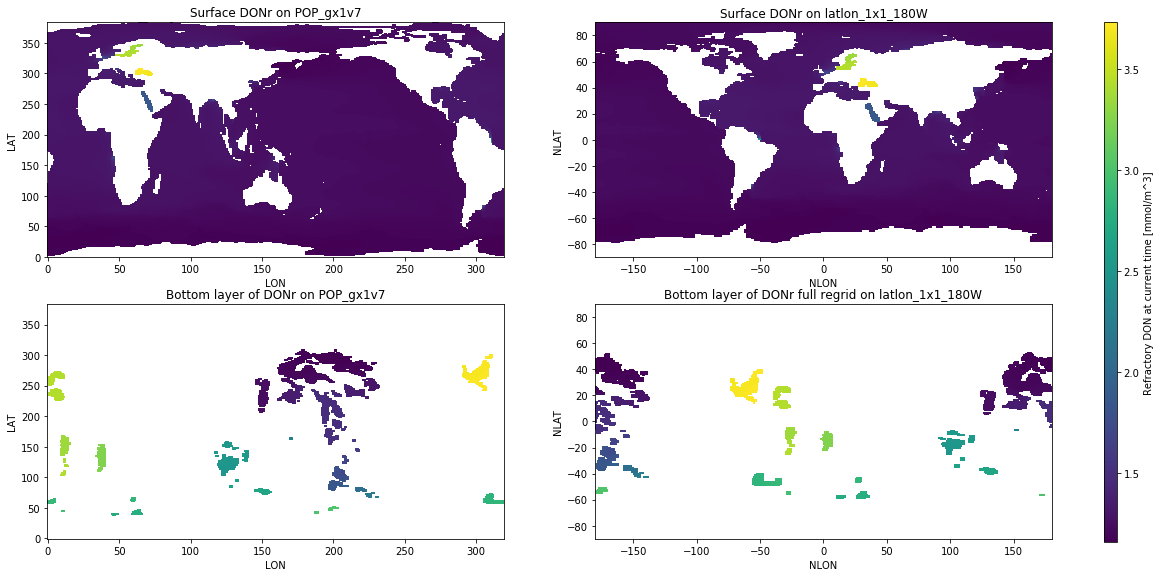


----

need to include DOP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.03686091665641624, 0.45830574492357545]
Range on output grid: [0.0, 0.45700454070996294]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


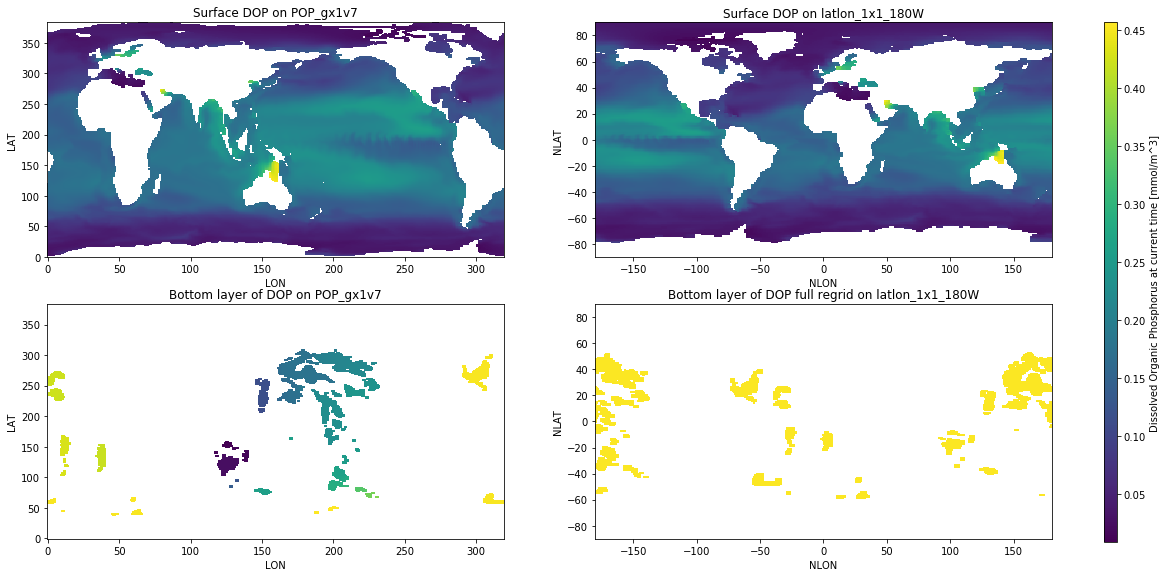


----

need to include DOPr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [0.011989150774992127, 0.04080309071704193]
Range on output grid: [0.011989150774992127, 0.04080309071704193]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


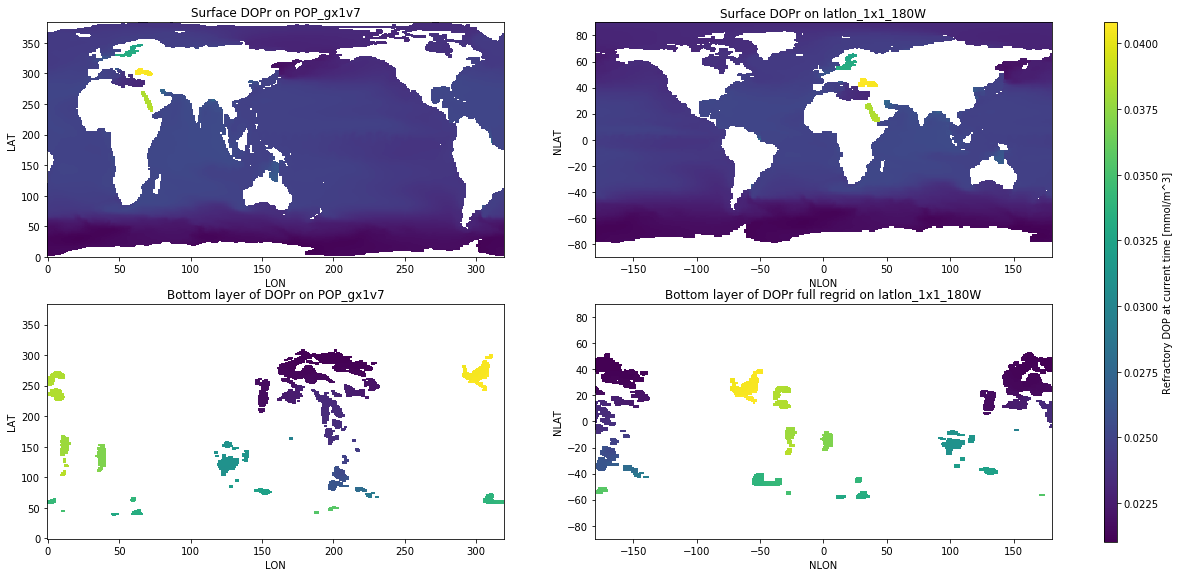


----

need to include NH4 from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.6628509210450839, 11.58724943201466]
Range on output grid: [0.0, 10.949921675092224]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


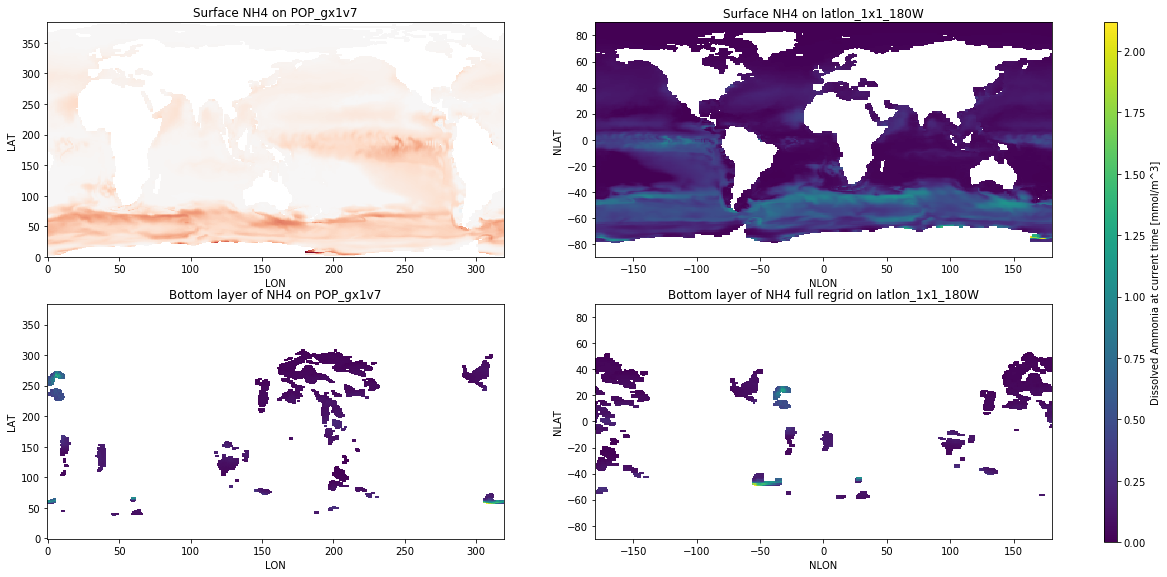


----

need to include Fe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [6.21352711782397e-06, 0.05490050537471074]
Range on output grid: [6.2208138928440165e-06, 0.05455459617809548]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


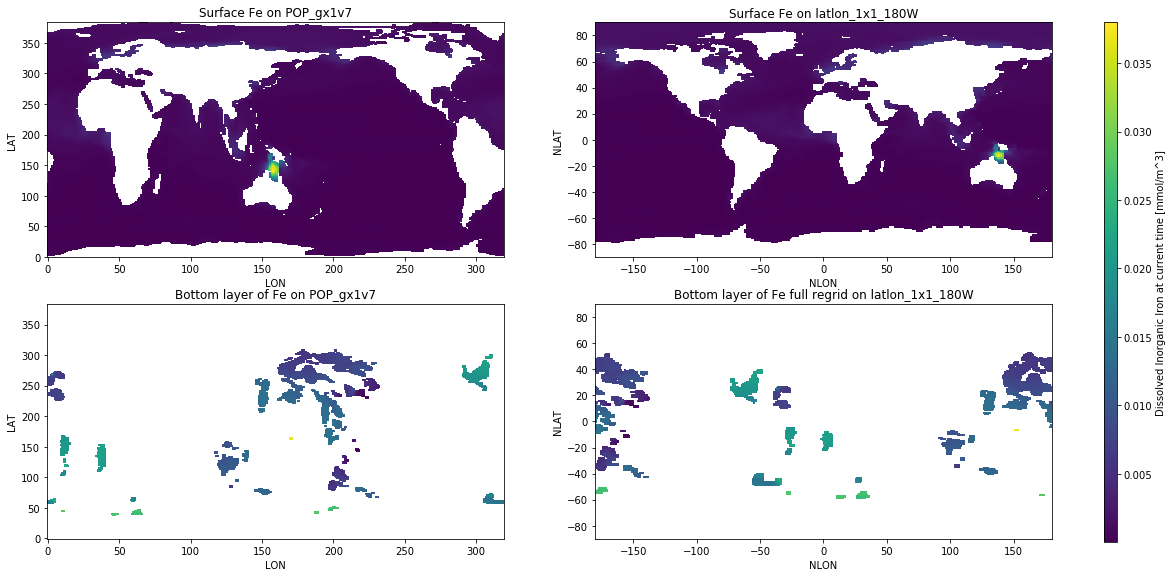


----

need to include Lig from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [0.0001411370979747286, 0.00296511536154731]
Range on output grid: [0.0003163380625078213, 0.002754886330504332]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


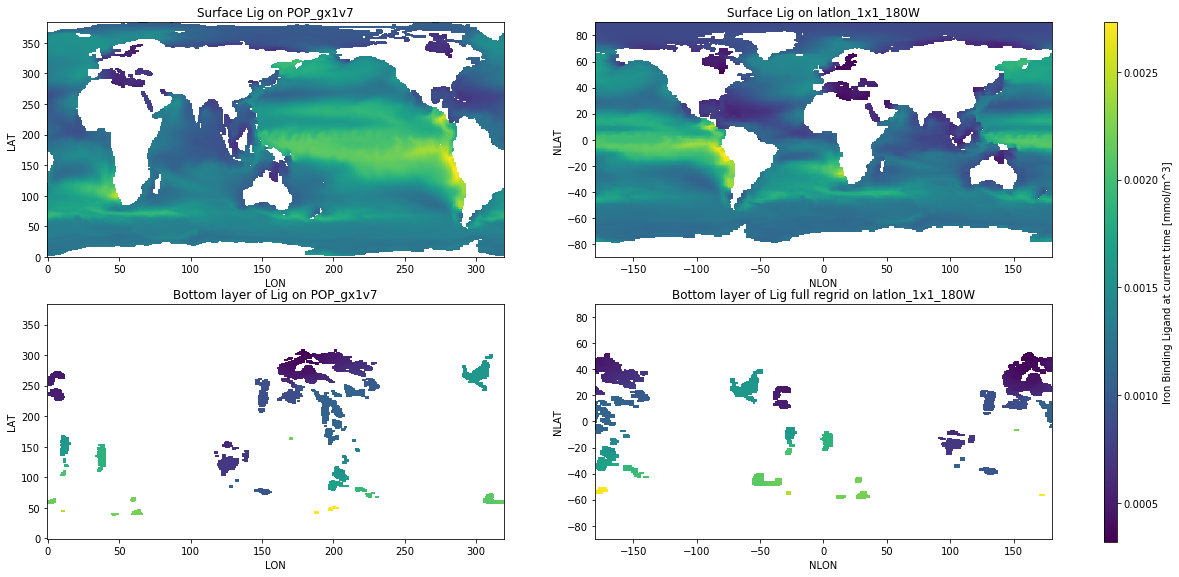


----

need to include coccoC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
coccoC is 7% of spC_CUR
Max = nan
Updating dimension
Range on POP grid: [-0.038821395816582456, 2.259280513391555]
Range on output grid: [0.0, 2.22680487524172]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


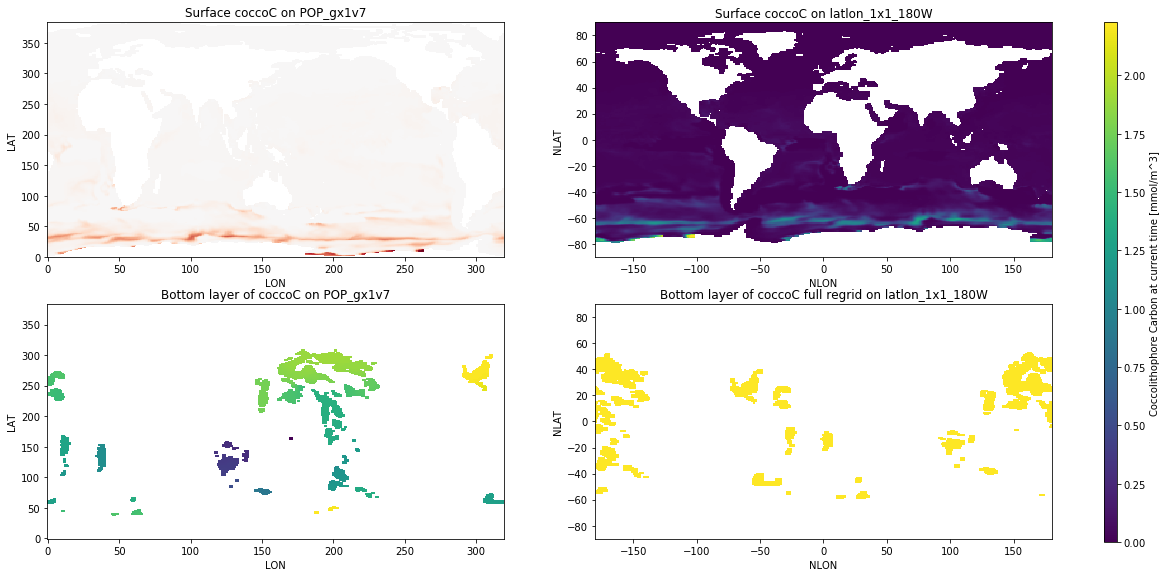


----

need to include coccoChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
coccoChl is 7% of spChl_CUR
Max = nan
Updating dimension
Range on POP grid: [-0.005356094155697751, 0.26618800174833734]
Range on output grid: [0.0, 0.26376938913539594]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


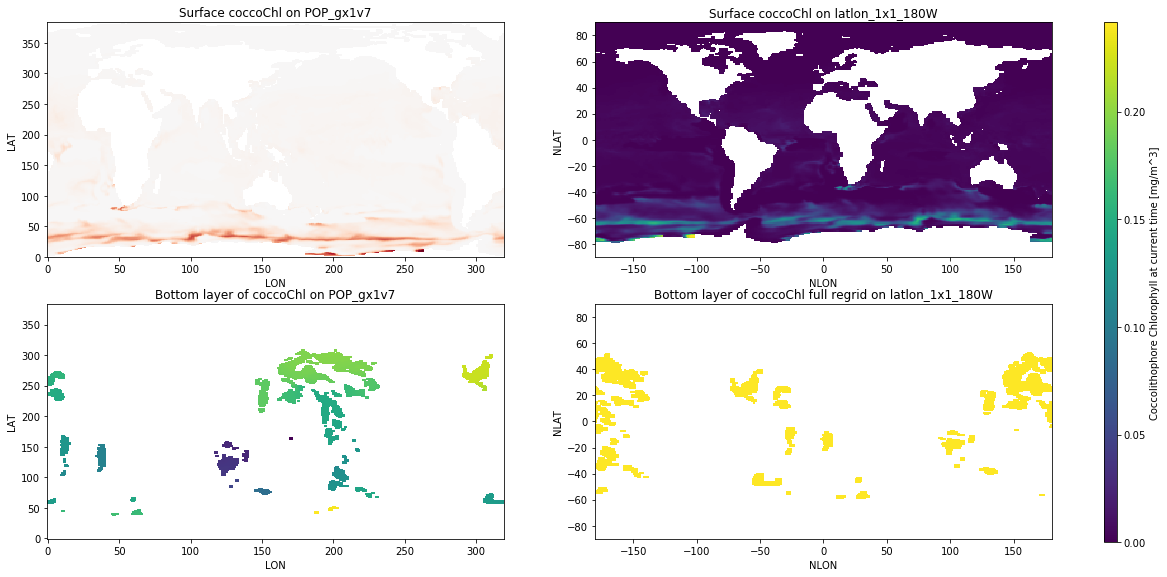


----

need to include coccoFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
coccoFe is 7% of spFe_CUR
Max = nan
Updating dimension
Range on POP grid: [-2.719861761300602e-07, 1.6731061406383897e-05]
Range on output grid: [0.0, 1.6415097610528e-05]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


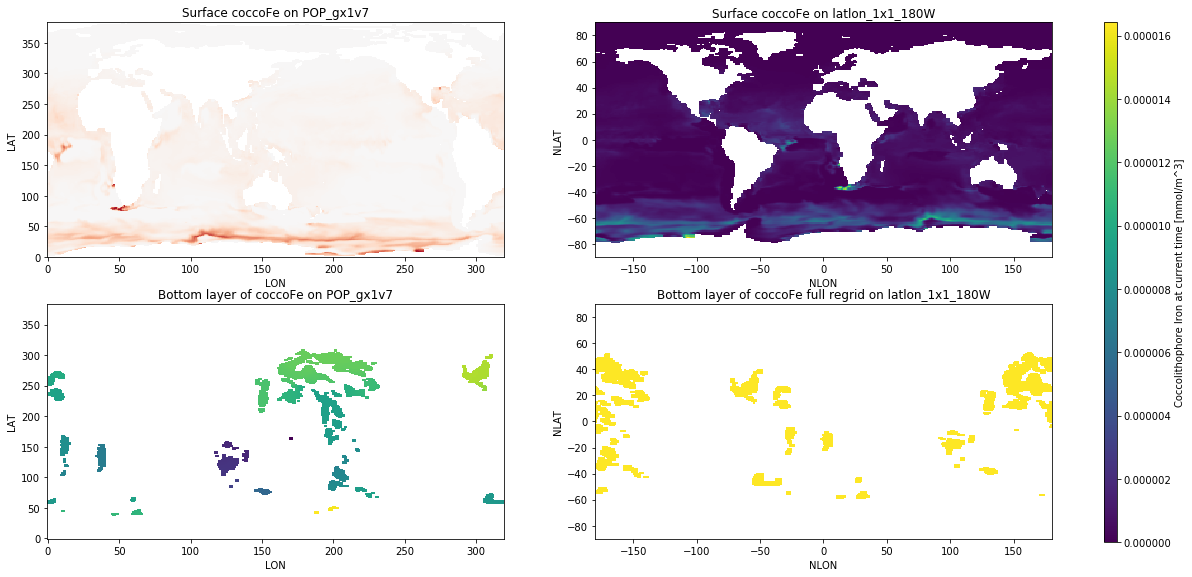


----

need to include coccoP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
coccoP is 7% of spP_CUR
Max = nan
Updating dimension
Range on POP grid: [-0.0003318069244322257, 0.019310093081508325]
Range on output grid: [0.0, 0.019032523477673136]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


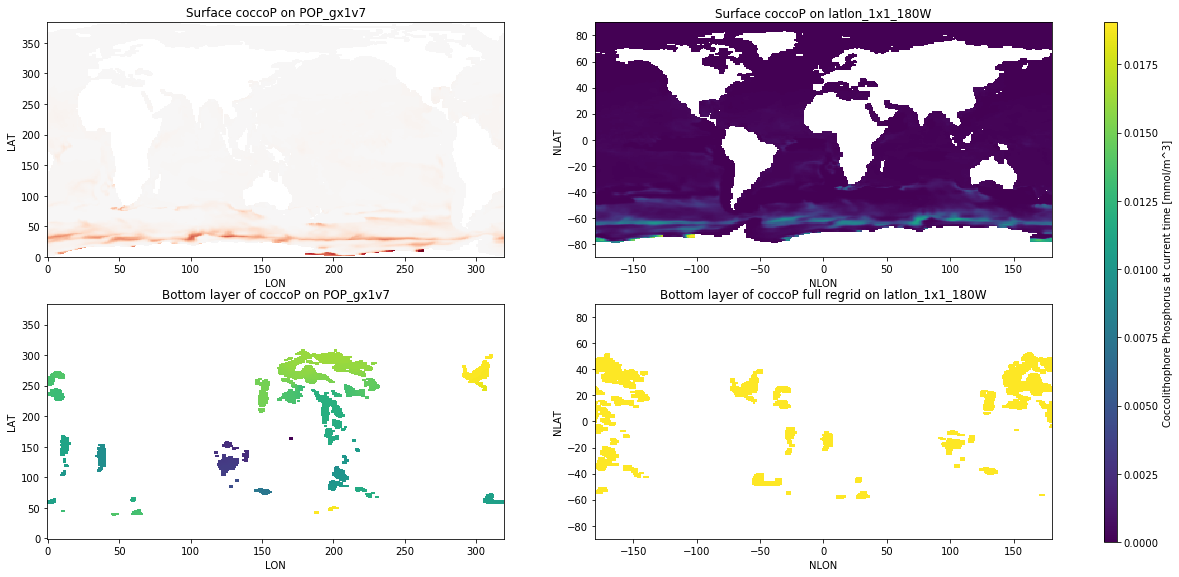


----

need to include coccoCaCO3 from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dimension
Range on POP grid: [-0.03056552111539826, 3.1199558230204216]
Range on output grid: [0.0, 2.9245703424059153]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


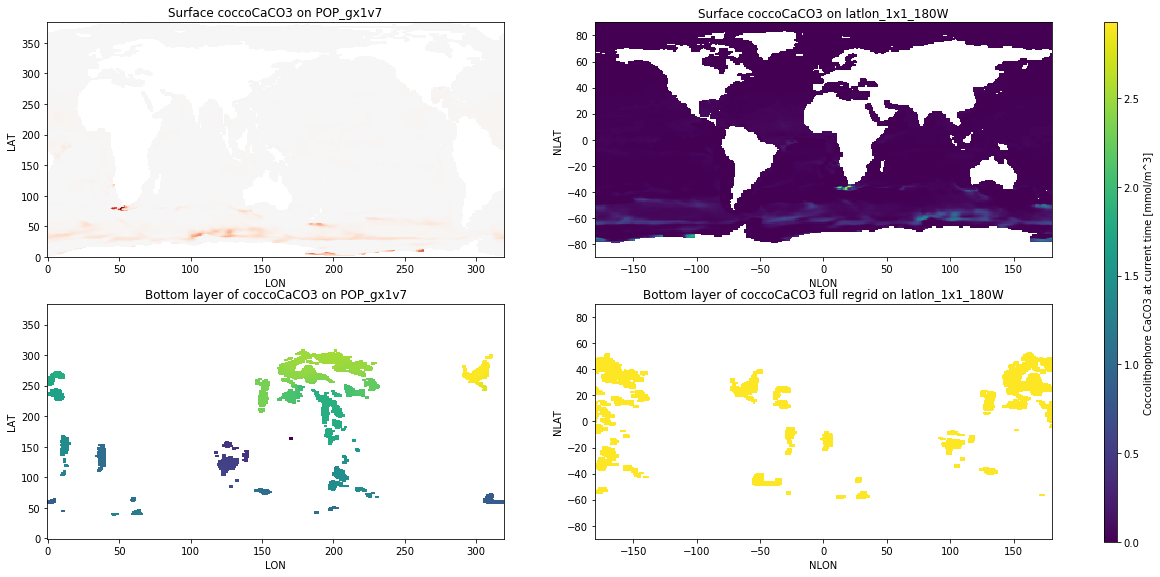


----

need to include microzooC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
microzooC is 56% of zooC
Max = 3.1878772912298476
Updating dimension
Range on POP grid: [-0.303312743931715, 3.1878772912298476]
Range on output grid: [0.0, 3.031689070459187]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


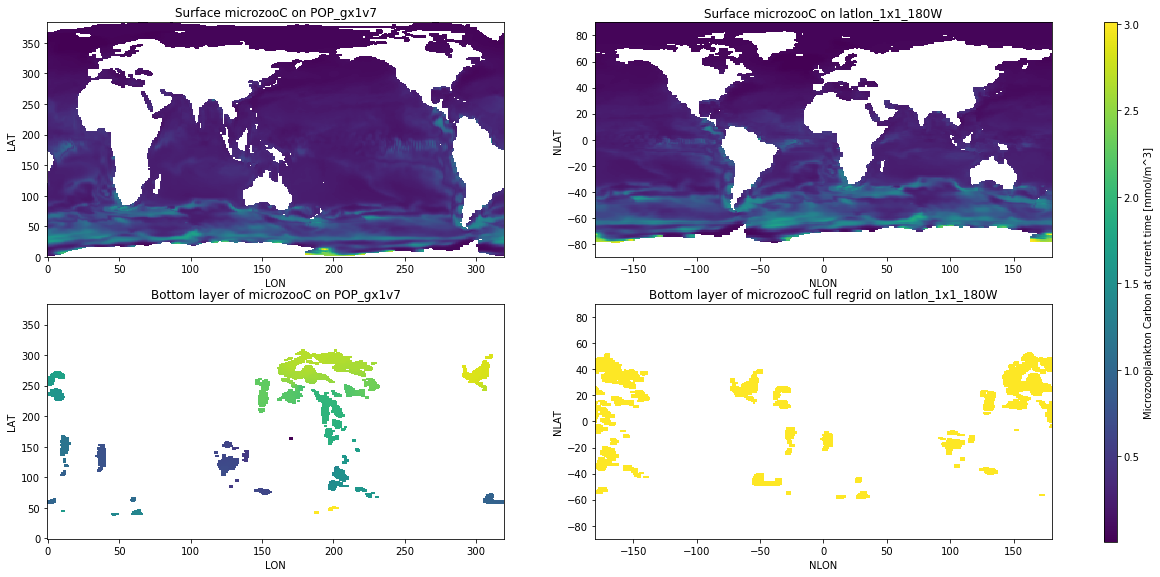


----

need to include mesozooC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
mesozooC is 44% of zooC
Max = nan
Updating dimension
Range on POP grid: [-0.1334576073299546, 1.402666008141133]
Range on output grid: [0.0, 1.3339431910020423]



/glade/work/mlevy/miniconda3/envs/marbl-forcing/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater_equal


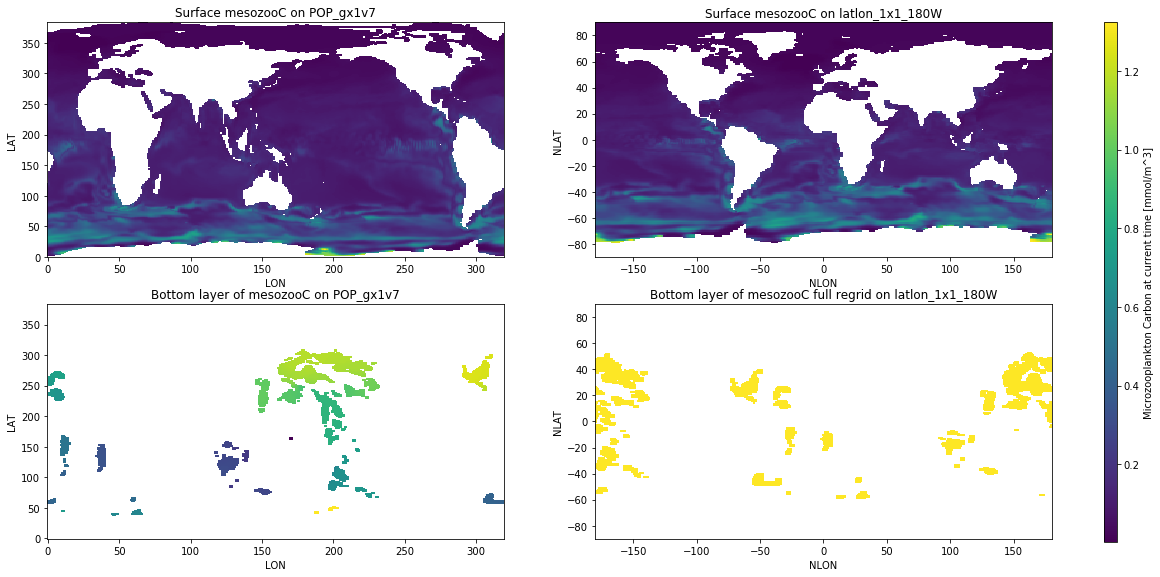


----

<xarray.Dataset>
Dimensions:     (DEPTH: 102, NLAT: 180, NLON: 360, time: 1)
Coordinates:
  * NLAT        (NLAT) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * NLON        (NLON) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * DEPTH       (DEPTH) float32 0.0 5.0 10.0 15.0 ... 5300.0 5400.0 5500.0
  * time        (time) float32 6.0
Data variables:
    TEMP        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SALT        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    NO3         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    PO4         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SiO3        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    O2          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DIC         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ALK         (DEPTH, NLAT, NLON) float64 nan nan nan n

In [10]:
%%time
# map tracers not yet in ds_out from refcase restart file to ds_out
fillvalue = -1.0e34 # value to replace land values with

src_grid = 'POP_gx1v7'
ds_refcase = xr.open_dataset(fname_refcase).rename({'k':'DEPTH', 'j':'LAT', 'i':'LON'})

# Set up POP vertical grid from POP's initial condition file
ds_vert = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/ic/ecosys_jan_IC_omip_POP_gx1v7_c190615.nc')
ds_src_grid = pop_tools.get_grid(src_grid)
ocnmask = (ds_src_grid["REGION_MASK"].values != 0)

# Will need vertical interpolation as well as horizontal!
for tracername in tracernames:
# for tracername in ['DOCr']:
    if tracername not in ds_out.data_vars:
        print(f'need to include {tracername} from {refcase} restart file')
        tracer_restname = tracername+'_CUR'
        if tracer_restname in ds_refcase.data_vars:
            tracer = ds_refcase[tracer_restname].rename(tracername)
            if tracername.startswith('sp') and add_cocco:
                print(f'Scaling {tracername} to 93%')
                print(f'Old max = {np.max(np.abs(tracer.data))}')
                tracer.data = 0.93*tracer.data
                print(f'New max = {np.max(np.abs(tracer.data))}')
        else:
            if tracername in cocco_tracers:
                sp_name = tracer_restname.replace('cocco', 'sp')
                tracer = ds_refcase[sp_name].rename(tracername)
                tracer.attrs['long_name'] = tracer.attrs['long_name'].replace('Small Phyto', 'Coccolithophore')
                if tracername != 'coccoCaCO3':
                    print(f'{tracername} is 7% of {sp_name}')
                    tracer.data = 0.07*tracer.data
                    print(f'Max = {np.max(np.abs(tracer.data))}')
            elif tracername == 'microzooC':
                tracer = ds_refcase['zooC_CUR'].rename(tracername)
                tracer.attrs['long_name'] = tracer.attrs['long_name'].replace('Zooplankton', 'Microzooplankton')
                print(f'{tracername} is 56% of zooC')
                tracer.data = 0.56*tracer.data
                print(f'Max = {np.max(np.abs(tracer.data))}')
            elif tracername == 'mesozooC':
                tracer = ds_refcase['zooC_CUR'].rename(tracername)
                tracer.attrs['long_name'] = tracer.attrs['long_name'].replace('Zooplankton', 'Mesozooplankton')
                print(f'{tracername} is 44% of zooC')
                tracer.data = 0.44*tracer.data
                print(f'Max = {np.max(np.abs(tracer.data))}')
        tracer.encoding['_FillValue'] = fillvalue
        nk_in = tracer.shape[0]

        # Set floor values that are 0.0 to value 1 layer shallower and mask out land.
        # This is to fill in values where KMT was popped up by overflow parameterization.
        # This is needed to enable using ds_out in runs where overflows are disabled.
        for k in range(1, nk_in):
            tracer.values[k, :, :] = np.where((tracer.values[k, :, :] == 0.0) & (k+1 == ds_vert.KMT.values),
                                       tracer.values[k-1, :, :], tracer.values[k, :, :])
        for k in range(nk_in):
            tracer.values[k, :, :] = np.where(k < ds_vert.KMT.values, tracer.values[k, :, :], np.nan)
        # print(f"Min value of {tracername} is {tracer.min().data}")
        # break

        # Plots on src grid
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.0, 9.5))
        # surface values
        plt.subplot(221)
        tracer.isel(DEPTH=0).plot(add_colorbar=False)
        plt.title(f"Surface {tracername} on {src_grid}")

        # bottom values
        plt.subplot(223)
        vmin, vmax = tracer.isel(DEPTH=-1).min(), tracer.isel(DEPTH=-1).max()
        tracer.isel(DEPTH=-1).plot(add_colorbar=False, vmin=vmin, vmax=vmax)
        plt.title(f"Bottom layer of {tracername} on {src_grid}")

        # perform lateral remapping
        regrid_operator = esmlab_regrid.regridder(
            name_grid_src=src_grid, name_grid_dst=dst_grid,
            method=interp_method, overwrite_existing=False)
        tracer_lateral_regrid = regrid_operator(tracer, renormalize=True)

        # generate vertical remapping weights
        depth_name_in = tracer.dims[0]
        depth_remap_weights = gen_remap_weights_1d(
            ds_vert['z_t_bounds'], DEPTH_bounds,
            ds_vert['z_t'].attrs['units'], 'm')

        # perform vertical remapping
        tracer_lateral_regrid_flat = tracer_lateral_regrid.values.reshape((nk_in, nj*ni))
        tracer_full_regrid_flat = depth_remap_weights.dot(tracer_lateral_regrid_flat)
        tracer_full_regrid_values = tracer_full_regrid_flat.reshape((nk, nj, ni))
        tracer_full_regrid = xr.DataArray(tracer_full_regrid_values, dims=('DEPTH', 'NLAT', 'NLON'),
                                          coords={'DEPTH':ds_out.DEPTH}, attrs=tracer.attrs)

        # perform lateral fill (need in mom_tools!)
        if dst_grid == 'MOM_tx0.66v1':
            tracer_full_regrid = tracer_full_regrid.where(MASK)
            tracer_full_regrid.encoding['_FillValue'] = fillvalue
            tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MASK, ltripole=ltripole)#, use_sor=True)
        if dst_grid == 'latlon_1x1_180W':
            print('Updating dimension')
            tracer_full_regrid = tracer_full_regrid.assign_coords(NLON=ds_out.NLON.data)
            tracer_full_regrid.encoding['_FillValue'] = fillvalue
            
        # Set negative values to 0
        tracer_full_regrid.data = np.where(np.logical_or(np.isnan(tracer_full_regrid), tracer_full_regrid.data >= 0), tracer_full_regrid.data, 0)

        # Note: vertical fill is done just prior to output
        ds_out[tracername] = tracer_full_regrid
        
        # Plot surface values
        plt.subplot(222)
        my_plot = ds_out[tracername].isel(DEPTH=0).plot(add_colorbar=False)
        plt.title(f'Surface {tracername} on {dst_grid}')
        cax = plt.axes((0.94, 0.12, 0.01, 0.76))
        cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
        cbar.set_label('{} [{}]'.format(tracer.attrs['long_name'],
                                        tracer.attrs['units']),
                                        rotation=90)
        # plot bottom layer (mom horizontal, mom vertical grid)
        plt.subplot(224)
        ds_out[tracername].isel(DEPTH=-1).plot(add_colorbar=False, vmin=vmin, vmax=vmax)
        plt.title(f"Bottom layer of {tracername} full regrid on {dst_grid}")

        print(f"Range on POP grid: [{tracer.min().data}, {tracer.max().data}]")
        print(f"Range on output grid: [{ds_out[tracername].min().data}, {ds_out[tracername].max().data}]\n")
        plt.show()
        print('\n----\n')

print(ds_out)

In [11]:
# set derived quantities

ds_out['DIC_ALT_CO2'] = ds_out['DIC']
ds_out['ABIO_DIC'] = xr.DataArray(1.025*ds_out['DIC'].data,
                                  dims=("DEPTH", "NLAT", "NLON"),
                                  attrs={'long_name': 'Abiotic dissolved inorganic carbon',
                                         'units': ds_out['DIC'].attrs['units'],
                                         'method': '1.025*DIC'}
                                 )
ds_out['ABIO_DI14C'] = xr.DataArray(0.9225*ds_out['DIC'].data,
                                  dims=("DEPTH", "NLAT", "NLON"),
                                  attrs={'long_name': 'Abiotic dissolved inorganic carbon-14',
                                         'units': ds_out['DIC'].attrs['units'],
                                         'method': '0.9225*DIC'}
                                 )
ds_out['ALK_ALT_CO2'] = ds_out['ALK']

ds_out['DEPTH'].attrs = {'positive': 'down',
                         'units': 'meters',
                         'axis': 'Z',
                         'point_spacing': 'uneven',
                         'standard_name': 'depth'}


# DOCtot = ds_out['DOC'].copy()
# DOCtot.values = ds_out['DOC'].values + ds_out['DOCr'].values
# DOCtot.attrs['long_name'] = 'DOC + DOCr'
# ds_out['DOCtot'] = DOCtot

dropvars = ['grid_dims', 'grid_center_lat', 'grid_center_lon', 'grid_corner_lat', 'grid_corner_lon', 'grid_imask', 'grid_area']
for var in dropvars:
    if var in ds_out.variables:
        ds_out = ds_out.drop(var)

ds_out

<xarray.Dataset>
Dimensions:      (DEPTH: 102, NLAT: 180, NLON: 360, time: 1)
Coordinates:
  * DEPTH        (DEPTH) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * NLAT         (NLAT) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * NLON         (NLON) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time         (time) float32 6.0
Data variables:
    TEMP         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SALT         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    NO3          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    PO4          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SiO3         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    O2           (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DIC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ALK          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spChl        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spFe         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spP          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatC        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatChl      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatFe       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatP        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatSi       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazC        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazChl      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazFe       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazP        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOCr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DON          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DONr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOP          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOPr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    NH4          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    Fe           (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    Lig          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    coccoC       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    coccoChl     (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    coccoFe      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    coccoP       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    coccoCaCO3   (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    microzooC    (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    mesozooC     (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DIC_ALT_CO2  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ABIO_DIC     (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ABIO_DI14C   (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan

In [12]:
def apply_bottom_value_to_subsurface_layers(da):
    """
    For ocean columns, if there are missing values below the bottom of the column we fill
    them with the values from the layer containing the ocean floor.
    
    This appears to be done in place in da, we do not need to return da and reassign ds_out[var].
    """
    MASK = np.isfinite(da.isel(DEPTH=0).data)
    unfilled = da.isnull() & (MASK == 1.)                    
    if unfilled.any():
        for k in range(1, nk):
            da[k, :, :] = xr.where(unfilled[k, :, :],
                                   da[k-1, :, :],
                                   da[k, :, :])
        if (da.isnull() & (MASK == 1.)).any():
            warnings.warn(f'{da.name} still has missing values')

def autotroph_consistency_check(ds):
    for autotroph in ['sp', 'diat', 'diaz']:
        zero_mask = ((ds[f'{autotroph}Chl'].data == 0) |
                     (ds[f'{autotroph}C'].data == 0) |
                     (ds[f'{autotroph}P'].data == 0) |
                     (ds[f'{autotroph}Fe'].data == 0))
        if f'{autotroph}Si' in ds.data_vars:
            zero_mask = zero_mask | (ds[f'{autotroph}Si'].data == 0)
        for tracer in ['Chl', 'C', 'P', 'Fe', 'Si', 'CaCO3']:
            tracer_name = f'{autotroph}{tracer}'
            if tracer_name in ds.data_vars:
                ds[tracer_name].data = np.where(zero_mask, 0, ds[tracer_name].data)
    return ds

ds_out = autotroph_consistency_check(ds_out)

for var in ds_out.data_vars:
    # Clean up attributes added by esmlab.regrid
    for attr in ['regrid_method', 'history']:
        if attr in ds_out[var].attrs:
            del ds_out[var].attrs[attr]
    # Fill sub-floor values with value from bottom of column
    if dst_grid == 'MOM_tx0.66v1':
        apply_bottom_value_to_subsurface_layers(ds_out[var])

In [13]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {id_string} on {datestamp}'
omip_file_list = [dirin_omip+'/'+omip_metadata[varname]['fname'] for varname in omip_metadata]
ds_out.attrs['input_file_list'] = ' '.join(omip_file_list + [fname_refcase])
util.ds_clean(ds_out).to_netcdf(fname_out)